# Diabetes Risk Factors Inference

## Sections
* [Packages import & Auxiliary functions](#Packages-import)  
* [Dataset loading & presentation](#Dataset-loading-and-presentation)  
* [Data cleaning](#Data-cleaning)  
    * [ Renaming columns](#Renaming-columns)  
    * [Data consistency and proper data type assignment](#Data-consistency-and-proper-data-type-assignment)  
    * [Dealing with unexpected $0$ values](#Dealing-with-unexpected-$0$-values)  
    * [Post cleaning dataset](#Post-cleaning-dataset)  
* [Exploratory data analysis](#Exploratory-data-analysis)  
    * [Univariate analysis](#Univariate-analysis)  
        * [Statistics](#Statistics)  
        * [Plots](#Plots)
    * [Bivariate analysis](#Bivariate-analysis)
        * [Numerical variables correlation](#Numerical-variables-correlation)
        * [Categorical variables association with numerical variables](#Categorical-variables-association-with-numerical-variables)
* [Unsupervised analysis](#Unsupervised-analysis)
    * [Encoding](#Encoding)
    * [Scaling](#Scaling)
    * [PCA](#PCA)
        * [Correlation circles](#Correlation-circles)
        * [Biplot](#Biplot)
    * [Clustering](#Clustering)
* [Supervised analysis](#Supervised-analysis)
    * [Models implementation PCA based](#Models-implementation-PCA-based)
        * [Data preprocessing](#Data-preprocessing)
        * [Support Vector Classifier](#Support-Vector-Classifier)
        * [Support Vector Machine, RBF Kernel](#Support-Vector-Machine,-RBF-Kernel)
        * [Logistic regression](#Logistic-regression)
        * [K-NN](#K-NN)
    * [Models implementation no-PCA based](#Models-implementation-no-PCA-based)
        * [Data preprocessing](#Data-preprocessing-)
        * [Support Vector Classifier](#Support-Vector-Classifier-)
        * [Support Vector Machine, RBF Kernel](#Support-Vector-Machine,-RBF-kernel-)
        * [Logistic regression](#Logistic-regression-)
        * [K-NN](#K-NN-)
    * [Models performance comparison](#Models-performance-comparison)
    * [Models interpretation](#Models-interpretation)
* [Conclusions](#Conclusions)

## Packages import

In [138]:
%%capture
!pip install ISLP

In [139]:
# Data management
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical packages
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from ISLP.svm import plot as plot_svm
from ISLP import confusion_table

# Other
import warnings

### Packages setup

In [140]:
# Setting plots theme
sns.set_theme()

### Auxiliary functions

In [141]:
def calculate_eta_squared(df, numeric_col, categorical_col):
    """Auxiliary function to calculate the ŋ² given two pandas.Series"""
      
    y = df[numeric_col]     
    groups = df.groupby(categorical_col)[numeric_col]          

    y_mean = y.mean()     
    ss_total = np.sum((y - y_mean)**2)          
   
    ss_between = 0
    for _, group_df in groups:         
        n_group = len(group_df)         
        y_group_mean = group_df.mean()         
        ss_between += n_group * (y_group_mean - y_mean)**2

    if ss_total == 0:         
        return 0             
    eta_squared = ss_between / ss_total     
    return eta_squared

def correlation_circle_graph(pca: PCA, columns: pd.Index, components: tuple):
    """Generates a correlation circle graph of the provided Principal Components based on a sklearn.Decomposition.PCA result"""
    
    plt.figure(figsize=(9, 9))

    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

    for index, column in enumerate(columns):
        x = pca.components_[components[0], index]
        y = pca.components_[components[1], index]
        if (x**2 + y**2)**0.5 > 0.2: 
            plt.arrow(0, 0, x, y, 
                      head_width=0.03, 
                      head_length=0.03, 
                      fc='r', 
                      ec='r')
            plt.text(x*1.15,
                     y*1.15,
                     column, 
                     color='black', 
                     ha='center', 
                     va='center', 
                     fontsize=9)
            
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel(f"PC{components[0] + 1} ({pca.explained_variance_ratio_[components[0]]*100:.1f}%)")
    plt.ylabel(f"PC{components[1] + 1} ({pca.explained_variance_ratio_[components[1]]*100:.1f}%)")
    plt.title("Correlation Circle (PCA Loadings)")
    plt.grid(False)
    plt.show()

def biplot(scores: np.ndarray, scores_idx: tuple, pca: PCA, columns: pd.Index, hue=None):
    """Generates a biplot of the first two Principal Components based on a sklearn.Decomposition.PCA result"""
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plotting scores    
    scores_x = scores[:, scores_idx[0]]
    scores_y = scores[:, scores_idx[1]]
    
    if hue is not None:
        ax1 = sns.scatterplot(x=scores_x, y=scores_y, hue=hue, alpha=0.5, palette='tab10')
    else:
        ax1 = sns.scatterplot(x=scores_x, y=scores_y, alpha=0.5)

    # Plotting loadings
    scaling_x = np.abs(scores_x).max()
    scaling_y = np.abs(scores_y).max()
    
    for index, column in enumerate(columns):
        arrow_x = pca.components_[scores_idx[0], index]
        arrow_y = pca.components_[scores_idx[1], index]
        
        if (arrow_x**2 + arrow_y**2)**0.5 > 0.15:
            arrow_x *= scaling_x
            arrow_y *= scaling_y
            
            plt.arrow(0, 0, arrow_x, arrow_y, 
                      head_width=scaling_x*0.03, 
                      head_length=scaling_y*0.03, 
                      fc='r', 
                      ec='r')
            plt.text(arrow_x + (arrow_x/abs(arrow_x))*(scaling_x/15),
                     arrow_y + (arrow_y/abs(arrow_y))*(scaling_y/15),
                     column, 
                     color='black', 
                     ha='center',
                     va='center', 
                     fontsize=9)
            
    plt.xlim(-1.1*scaling_x, 1.1*scaling_x)
    plt.ylim(-1.1*scaling_y, 1.1*scaling_y)
    plt.xlabel(f"PC1 (scores)")
    plt.ylabel(f"PC2 (scores)")       
    plt.grid(True, linestyle='--', alpha=0.5)    
    plt.axhline(0, color='black', linewidth=1, alpha=0.5)
    plt.axvline(0, color='black', linewidth=1, alpha=0.5)
    plt.title("PC1-PC2 Biplot")
    
    plt.show()

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[0].min() - 1, X[0].max() + 1
    y_min, y_max = X[1].min() - 1, X[1].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid_size = xx.ravel().shape[0]
    full_grid = np.zeros((grid_size, 4))

    full_grid[:, 0] = xx.ravel()
    full_grid[:, 1] = yy.ravel()

    preds = model.predict(full_grid).reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.4, cmap="viridis")
    plt.scatter(X[0], X[1], c=y, cmap="viridis", edgecolors="k")
    plt.title("Multiclass Logistic Regression Decision Boundaries")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    #plt.show()

def plot_multiclass_decision_boundary_nopca(model, X, y, cols):
    x_min, x_max = X[cols[0]].min() - 1, X[cols[0]].max() + 1
    y_min, y_max = X[cols[1]].min() - 1, X[cols[1]].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    
    grid_size = xx.ravel().shape[0]
    full_grid = np.zeros((grid_size, len(X.columns)))
    
    full_grid[:, 0] = xx.ravel()
    full_grid[:, 1] = yy.ravel()
    
    preds = model.predict(full_grid).reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.4, cmap="viridis")
    plt.scatter(X[cols[0]], X[cols[1]], c=y, cmap="viridis", edgecolors="k")
    plt.title("Multiclass Logistic Regression Decision Boundaries")
    plt.xlabel(cols[0])
    plt.ylabel(cols[1])

## Dataset loading and presentation
**Dataset overview**  
Reference: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database  
The dataset employed in this analysis has been created by the National Institute of Diabetes and Digestive and Kidney Diseases. The dataset provides several information about patients and whether or not a patient has diabetes. Also, all the patients of the dataset are females at least 21 years old of Pima Indian heritage.  

**Why this dataset?**  
Statistical tools can be applied in order to uncover underlying data patterns between biological information obtained from the human body that could not be so visible from a manual review. By analyzing this type of dataset and discovering what are the symptoms that can lead to diabetes, it can be possible to act preventively and mitigate complications and potentially save lives. 

In [142]:
df_raw = pd.read_csv(r"data/diabetes.csv")

In [143]:
df_raw.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [144]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [145]:
df_raw.shape

(768, 9)

The dataset is composed by 768 observations and by the 9 following variables:
- `Pregnancies`: number of times pregnant
    - discrete numerical
- `Glucose`: plasma glucose concentration at 2 hours in an oral glucose tolerance test
    - discrete numerical
- `BloodPressure`: diastolic blood pressure (mmHg)
    - discrete numerical
- `SkinThickness`: triceps skin fold thickness (mm)
    - discrete numerical
- `Insulin`: 2 hour serum insulin (μU/ml)
    - discrete numerical
- `BMI`: body mass index (kg/m^2)
    - continuous numerical
- `DiabetesPedigreeFunction`: diabetes pedigree function
    - continuous numerical
- `Age`: age (years)
    - discrete numerical
- `Outcome`: whether or not the patient has diabetes
    - categorical nominal, in particular it is binary (present=`0`, absent=`1`)

## Data cleaning

### Renaming columns

In [146]:
df_raw = df_raw.rename(columns={'Pregnancies': 'pregnancies',
                                'Glucose': 'glucose',
                                'BloodPressure': 'blood_pressure',
                                'SkinThickness': 'skin_thickness',
                                'Insulin': 'insulin',
                                'BMI': 'bmi',
                                'DiabetesPedigreeFunction': 'diabetes_pedigree',
                                'Age': 'age',
                                'Outcome': 'outcome'})

### Data consistency and proper data type assignment

#### Pregnancies

In [147]:
df_raw['pregnancies'].unique()

array([ 6,  1,  8,  0,  5,  3, 10,  2,  4,  7,  9, 11, 13, 15, 17, 12, 14])

In [148]:
df_raw['pregnancies'].value_counts().sort_index()

pregnancies
0     111
1     135
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
12      9
13     10
14      2
15      1
17      1
Name: count, dtype: int64

Values are consistent with the variable meaning

#### Glucose

In [149]:
df_raw['glucose'].unique()

array([148,  85, 183,  89, 137, 116,  78, 115, 197, 125, 110, 168, 139,
       189, 166, 100, 118, 107, 103, 126,  99, 196, 119, 143, 147,  97,
       145, 117, 109, 158,  88,  92, 122, 138, 102,  90, 111, 180, 133,
       106, 171, 159, 146,  71, 105, 101, 176, 150,  73, 187,  84,  44,
       141, 114,  95, 129,  79,   0,  62, 131, 112, 113,  74,  83, 136,
        80, 123,  81, 134, 142, 144,  93, 163, 151,  96, 155,  76, 160,
       124, 162, 132, 120, 173, 170, 128, 108, 154,  57, 156, 153, 188,
       152, 104,  87,  75, 179, 130, 194, 181, 135, 184, 140, 177, 164,
        91, 165,  86, 193, 191, 161, 167,  77, 182, 157, 178,  61,  98,
       127,  82,  72, 172,  94, 175, 195,  68, 186, 198, 121,  67, 174,
       199,  56, 169, 149,  65, 190])

In [150]:
df_raw['glucose'].value_counts().sort_index()

glucose
0      5
44     1
56     1
57     2
61     1
      ..
195    2
196    3
197    4
198    1
199    1
Name: count, Length: 136, dtype: int64

Most of the values are consistent with the variable meaning besides the patient having `glucose=0`. Requires further investigation.

#### Blood pressure

In [151]:
df_raw['blood_pressure'].unique()

array([ 72,  66,  64,  40,  74,  50,   0,  70,  96,  92,  80,  60,  84,
        30,  88,  90,  94,  76,  82,  75,  58,  78,  68, 110,  56,  62,
        85,  86,  48,  44,  65, 108,  55, 122,  54,  52,  98, 104,  95,
        46, 102, 100,  61,  24,  38, 106, 114])

In [152]:
df_raw['blood_pressure'].value_counts().sort_index()

blood_pressure
0      35
24      1
30      2
38      1
40      1
44      4
46      2
48      5
50     13
52     11
54     11
55      2
56     12
58     21
60     37
61      1
62     34
64     43
65      7
66     30
68     45
70     57
72     44
74     52
75      8
76     39
78     45
80     40
82     30
84     23
85      6
86     21
88     25
90     22
92      8
94      6
95      1
96      4
98      3
100     3
102     1
104     2
106     3
108     2
110     3
114     1
122     1
Name: count, dtype: int64

Most of the values are consistent with the variable meaning besides the patients having `blood_pressure=0`. Requires further investigation.

#### Skin thickness

In [153]:
df_raw['skin_thickness'].unique()

array([35, 29,  0, 23, 32, 45, 19, 47, 38, 30, 41, 33, 26, 15, 36, 11, 31,
       37, 42, 25, 18, 24, 39, 27, 21, 34, 10, 60, 13, 20, 22, 28, 54, 40,
       51, 56, 14, 17, 50, 44, 12, 46, 16,  7, 52, 43, 48,  8, 49, 63, 99])

In [154]:
df_raw['skin_thickness'].value_counts().sort_index()

skin_thickness
0     227
7       2
8       2
10      5
11      6
12      7
13     11
14      6
15     14
16      6
17     14
18     20
19     18
20     13
21     10
22     16
23     22
24     12
25     16
26     16
27     23
28     20
29     17
30     27
31     19
32     31
33     20
34      8
35     15
36     14
37     16
38      7
39     18
40     16
41     15
42     11
43      6
44      5
45      6
46      8
47      4
48      4
49      3
50      3
51      1
52      2
54      2
56      1
60      1
63      1
99      1
Name: count, dtype: int64

Most of the values are consistent with the variable meaning besides the patients having `skin_thickness=0`. Requires further investigation.

#### Insulin

In [155]:
df_raw['insulin'].unique()

array([  0,  94, 168,  88, 543, 846, 175, 230,  83,  96, 235, 146, 115,
       140, 110, 245,  54, 192, 207,  70, 240,  82,  36,  23, 300, 342,
       304, 142, 128,  38, 100,  90, 270,  71, 125, 176,  48,  64, 228,
        76, 220,  40, 152,  18, 135, 495,  37,  51,  99, 145, 225,  49,
        50,  92, 325,  63, 284, 119, 204, 155, 485,  53, 114, 105, 285,
       156,  78, 130,  55,  58, 160, 210, 318,  44, 190, 280,  87, 271,
       129, 120, 478,  56,  32, 744, 370,  45, 194, 680, 402, 258, 375,
       150,  67,  57, 116, 278, 122, 545,  75,  74, 182, 360, 215, 184,
        42, 132, 148, 180, 205,  85, 231,  29,  68,  52, 255, 171,  73,
       108,  43, 167, 249, 293,  66, 465,  89, 158,  84,  72,  59,  81,
       196, 415, 275, 165, 579, 310,  61, 474, 170, 277,  60,  14,  95,
       237, 191, 328, 250, 480, 265, 193,  79,  86, 326, 188, 106,  65,
       166, 274,  77, 126, 330, 600, 185,  25,  41, 272, 321, 144,  15,
       183,  91,  46, 440, 159, 540, 200, 335, 387,  22, 291, 39

In [156]:
df_raw['insulin'].value_counts().sort_index()

insulin
0      374
14       1
15       1
16       1
18       2
      ... 
579      1
600      1
680      1
744      1
846      1
Name: count, Length: 186, dtype: int64

Most of the values are consistent with the variable meaning besides the patients having `insulin=0`. Requires further investigation.

#### BMI

In [157]:
df_raw['bmi'].unique()

array([33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31. , 35.3, 30.5,  0. , 37.6,
       38. , 27.1, 30.1, 25.8, 30. , 45.8, 29.6, 43.3, 34.6, 39.3, 35.4,
       39.8, 29. , 36.6, 31.1, 39.4, 23.2, 22.2, 34.1, 36. , 31.6, 24.8,
       19.9, 27.6, 24. , 33.2, 32.9, 38.2, 37.1, 34. , 40.2, 22.7, 45.4,
       27.4, 42. , 29.7, 28. , 39.1, 19.4, 24.2, 24.4, 33.7, 34.7, 23. ,
       37.7, 46.8, 40.5, 41.5, 25. , 25.4, 32.8, 32.5, 42.7, 19.6, 28.9,
       28.6, 43.4, 35.1, 32. , 24.7, 32.6, 43.2, 22.4, 29.3, 24.6, 48.8,
       32.4, 38.5, 26.5, 19.1, 46.7, 23.8, 33.9, 20.4, 28.7, 49.7, 39. ,
       26.1, 22.5, 39.6, 29.5, 34.3, 37.4, 33.3, 31.2, 28.2, 53.2, 34.2,
       26.8, 55. , 42.9, 34.5, 27.9, 38.3, 21.1, 33.8, 30.8, 36.9, 39.5,
       27.3, 21.9, 40.6, 47.9, 50. , 25.2, 40.9, 37.2, 44.2, 29.9, 31.9,
       28.4, 43.5, 32.7, 67.1, 45. , 34.9, 27.7, 35.9, 22.6, 33.1, 30.4,
       52.3, 24.3, 22.9, 34.8, 30.9, 40.1, 23.9, 37.5, 35.5, 42.8, 42.6,
       41.8, 35.8, 37.8, 28.8, 23.6, 35.7, 36.7, 45

In [158]:
df_raw['bmi'].value_counts().sort_index()

bmi
0.0     11
18.2     3
18.4     1
19.1     1
19.3     1
        ..
53.2     1
55.0     1
57.3     1
59.4     1
67.1     1
Name: count, Length: 248, dtype: int64

Most of the values are consistent with the variable meaning besides the patients having `bmi=0`. Requires further investigation.

#### Diabetes pedigree

In [159]:
df_raw['diabetes_pedigree'].unique()

array([0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.248, 0.134, 0.158,
       0.232, 0.191, 0.537, 1.441, 0.398, 0.587, 0.484, 0.551, 0.254,
       0.183, 0.529, 0.704, 0.388, 0.451, 0.263, 0.205, 0.257, 0.487,
       0.245, 0.337, 0.546, 0.851, 0.267, 0.188, 0.512, 0.966, 0.42 ,
       0.665, 0.503, 1.39 , 0.271, 0.696, 0.235, 0.721, 0.294, 1.893,
       0.564, 0.586, 0.344, 0.305, 0.491, 0.526, 0.342, 0.467, 0.718,
       0.962, 1.781, 0.173, 0.304, 0.27 , 0.699, 0.258, 0.203, 0.855,
       0.845, 0.334, 0.189, 0.867, 0.411, 0.583, 0.231, 0.396, 0.14 ,
       0.391, 0.37 , 0.307, 0.102, 0.767, 0.237, 0.227, 0.698, 0.178,
       0.324, 0.153, 0.165, 0.443, 0.261, 0.277, 0.761, 0.255, 0.13 ,
       0.323, 0.356, 0.325, 1.222, 0.179, 0.262, 0.283, 0.93 , 0.801,
       0.207, 0.287, 0.336, 0.247, 0.199, 0.543, 0.192, 0.588, 0.539,
       0.22 , 0.654, 0.223, 0.759, 0.26 , 0.404, 0.186, 0.278, 0.496,
       0.452, 0.403, 0.741, 0.361, 1.114, 0.457, 0.647, 0.088, 0.597,
       0.532, 0.703,

In [160]:
df_raw['diabetes_pedigree'].value_counts().sort_index()

diabetes_pedigree
0.078    1
0.084    1
0.085    2
0.088    2
0.089    1
        ..
1.893    1
2.137    1
2.288    1
2.329    1
2.420    1
Name: count, Length: 517, dtype: int64

Values are consistent with the variable meaning

#### Age

In [161]:
df_raw['age'].unique()

array([50, 31, 32, 21, 33, 30, 26, 29, 53, 54, 34, 57, 59, 51, 27, 41, 43,
       22, 38, 60, 28, 45, 35, 46, 56, 37, 48, 40, 25, 24, 58, 42, 44, 39,
       36, 23, 61, 69, 62, 55, 65, 47, 52, 66, 49, 63, 67, 72, 81, 64, 70,
       68])

In [162]:
df_raw['age'].value_counts().sort_index()

age
21    63
22    72
23    38
24    46
25    48
26    33
27    32
28    35
29    29
30    21
31    24
32    16
33    17
34    14
35    10
36    16
37    19
38    16
39    12
40    13
41    22
42    18
43    13
44     8
45    15
46    13
47     6
48     5
49     5
50     8
51     8
52     8
53     5
54     6
55     4
56     3
57     5
58     7
59     3
60     5
61     2
62     4
63     4
64     1
65     3
66     4
67     3
68     1
69     2
70     1
72     1
81     1
Name: count, dtype: int64

Values are consistent with the variable meaning

#### Outcome

In [163]:
df_raw['outcome'].unique()

array([1, 0])

In [164]:
df_raw['outcome'].value_counts()

outcome
0    500
1    268
Name: count, dtype: int64

In [165]:
df_raw['outcome'] = df_raw['outcome'].replace({0: 'absent', 1: 'present'})
df_raw['outcome'] = df_raw['outcome'].astype(pd.CategoricalDtype(categories=['absent', 'present'], ordered=False))

The two classes appear to be mildly unbalanced

In [166]:
df_raw['outcome'].value_counts().iloc[0]

np.int64(500)

In [167]:
print(f"Patients with diabetes: {df_raw['outcome'].value_counts().iloc[0]*100/len(df_raw['outcome']):.2f}%\n\
Patients without diabetes: {df_raw['outcome'].value_counts().iloc[1]*100/len(df_raw['outcome']):.2f}%")

Patients with diabetes: 65.10%
Patients without diabetes: 34.90%


### Dealing with unexpected $0$ values
Several variables showed unexpected values according to what the variable range of values should be.

#### Glucose

In [168]:
df_raw[df_raw['glucose'] == 0]

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
75             1        0              48              20        0  24.7   
182            1        0              74              20       23  27.7   
342            1        0              68              35        0  32.0   
349            5        0              80              32        0  41.0   
502            6        0              68              41        0  39.0   

     diabetes_pedigree  age  outcome  
75               0.140   22   absent  
182              0.299   21   absent  
342              0.389   22   absent  
349              0.346   37  present  
502              0.727   41  present

#### Blood pressure

In [169]:
df_raw[df_raw['blood_pressure'] == 0]

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
7             10      115               0               0        0  35.3   
15             7      100               0               0        0  30.0   
49             7      105               0               0        0   0.0   
60             2       84               0               0        0   0.0   
78             0      131               0               0        0  43.2   
81             2       74               0               0        0   0.0   
172            2       87               0              23        0  28.9   
193           11      135               0               0        0  52.3   
222            7      119               0               0        0  25.2   
261            3      141               0               0        0  30.0   
266            0      138               0               0        0  36.3   
269            2      146               0               0        0  27.5   
300            0      167               0               0        0  32.3   
332            1      180               0               0        0  43.3   
336            0      117               0               0        0  33.8   
347            3      116               0               0        0  23.5   
357           13      129               0              30        0  39.9   
426            0       94               0               0        0   0.0   
430            2       99               0               0        0  22.2   
435            0      141               0               0        0  42.4   
453            2      119               0               0        0  19.6   
468            8      120               0               0        0  30.0   
484            0      145               0               0        0  44.2   
494            3       80               0               0        0   0.0   
522            6      114               0               0        0   0.0   
533            6       91               0               0        0  29.8   
535            4      132               0               0        0  32.9   
589            0       73               0               0        0  21.1   
601            6       96               0               0        0  23.7   
604            4      183               0               0        0  28.4   
619            0      119               0               0        0  32.4   
643            4       90               0               0        0  28.0   
697            0       99               0               0        0  25.0   
703            2      129               0               0        0  38.5   
706           10      115               0               0        0   0.0   

     diabetes_pedigree  age  outcome  
7                0.134   29   absent  
15               0.484   32  present  
49               0.305   24   absent  
60               0.304   21   absent  
78               0.270   26  present  
81               0.102   22   absent  
172              0.773   25   absent  
193              0.578   40  present  
222              0.209   37   absent  
261              0.761   27  present  
266              0.933   25  present  
269              0.240   28  present  
300              0.839   30  present  
332              0.282   41  present  
336              0.932   44   absent  
347              0.187   23   absent  
357              0.569   44  present  
426              0.256   25   absent  
430              0.108   23   absent  
435              0.205   29  present  
453              0.832   72   absent  
468              0.183   38  present  
484              0.630   31  present  
494              0.174   22   absent  
522              0.189   26   absent  
533              0.501   31   absent  
535              0.302   23  present  
589              0.342   25   absent  
601              0.190   28   absent  
604              0.212   36  present  
619              0.141   24  present  
643              0.6

#### Skin thickness

In [170]:
df_raw[df_raw['skin_thickness'] == 0]

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
2              8      183              64               0        0  23.3   
5              5      116              74               0        0  25.6   
7             10      115               0               0        0  35.3   
9              8      125              96               0        0   0.0   
10             4      110              92               0        0  37.6   
..           ...      ...             ...             ...      ...   ...   
757            0      123              72               0        0  36.3   
758            1      106              76               0        0  37.5   
759            6      190              92               0        0  35.5   
762            9       89              62               0        0  22.5   
766            1      126              60               0        0  30.1   

     diabetes_pedigree  age  outcome  
2                0.672   32  present  
5                0.201   30   absent  
7                0.134   29   absent  
9                0.232   54  present  
10               0.191   30   absent  
..                 ...  ...      ...  
757              0.258   52  present  
758              0.197   26   absent  
759              0.278   66  present  
762              0.142   33   absent  
766              0.349   47  present  

[227 rows x 9 columns]

#### Insulin

In [171]:
df_raw[df_raw['insulin'] == 0]

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
0              6      148              72              35        0  33.6   
1              1       85              66              29        0  26.6   
2              8      183              64               0        0  23.3   
5              5      116              74               0        0  25.6   
7             10      115               0               0        0  35.3   
..           ...      ...             ...             ...      ...   ...   
761            9      170              74              31        0  44.0   
762            9       89              62               0        0  22.5   
764            2      122              70              27        0  36.8   
766            1      126              60               0        0  30.1   
767            1       93              70              31        0  30.4   

     diabetes_pedigree  age  outcome  
0                0.627   50  present  
1                0.351   31   absent  
2                0.672   32  present  
5                0.201   30   absent  
7                0.134   29   absent  
..                 ...  ...      ...  
761              0.403   43  present  
762              0.142   33   absent  
764              0.340   27   absent  
766              0.349   47  present  
767              0.315   23   absent  

[374 rows x 9 columns]

#### BMI

In [172]:
df_raw[df_raw['bmi'] == 0]

pregnancies  glucose  blood_pressure  skin_thickness  insulin  bmi  \
9              8      125              96               0        0  0.0   
49             7      105               0               0        0  0.0   
60             2       84               0               0        0  0.0   
81             2       74               0               0        0  0.0   
145            0      102              75              23        0  0.0   
371            0      118              64              23       89  0.0   
426            0       94               0               0        0  0.0   
494            3       80               0               0        0  0.0   
522            6      114               0               0        0  0.0   
684            5      136              82               0        0  0.0   
706           10      115               0               0        0  0.0   

     diabetes_pedigree  age  outcome  
9                0.232   54  present  
49               0.305   24   absent  
60               0.304   21   absent  
81               0.102   22   absent  
145              0.572   21   absent  
371              1.731   21   absent  
426              0.256   25   absent  
494              0.174   22   absent  
522              0.189   26   absent  
684              0.640   69   absent  
706              0.261   30  present

#### Total

In [173]:
df_unexp = df_raw[(df_raw['glucose'] == 0) | (df_raw['blood_pressure'] == 0) | (df_raw['skin_thickness'] == 0) | (df_raw['insulin'] == 0) | (df_raw['bmi'] == 0)]
df_unexp

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
0              6      148              72              35        0  33.6   
1              1       85              66              29        0  26.6   
2              8      183              64               0        0  23.3   
5              5      116              74               0        0  25.6   
7             10      115               0               0        0  35.3   
..           ...      ...             ...             ...      ...   ...   
761            9      170              74              31        0  44.0   
762            9       89              62               0        0  22.5   
764            2      122              70              27        0  36.8   
766            1      126              60               0        0  30.1   
767            1       93              70              31        0  30.4   

     diabetes_pedigree  age  outcome  
0                0.627   50  present  
1                0.351   31   absent  
2                0.672   32  present  
5                0.201   30   absent  
7                0.134   29   absent  
..                 ...  ...      ...  
761              0.403   43  present  
762              0.142   33   absent  
764              0.340   27   absent  
766              0.349   47  present  
767              0.315   23   absent  

[376 rows x 9 columns]

In [174]:
df_unexp['outcome'].value_counts()

outcome
absent     238
present    138
Name: count, dtype: int64

There is a total of `376` rows with unexpected values where `238` belong to the `absent` class and `138` to the `present` class. Dropping these rows keeps the classes proportion still the same and the total amount of observations is still big enough to be allow for the upcoming analysis so the rows are just dropped.

In [175]:
df_raw = df_raw[(df_raw['glucose'] > 0) &
                (df_raw['blood_pressure'] > 0) &
                (df_raw['skin_thickness'] > 0) &
                (df_raw['insulin'] > 0) &
                (df_raw['bmi'] > 0)]
df_raw

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
3              1       89              66              23       94  28.1   
4              0      137              40              35      168  43.1   
6              3       78              50              32       88  31.0   
8              2      197              70              45      543  30.5   
13             1      189              60              23      846  30.1   
..           ...      ...             ...             ...      ...   ...   
753            0      181              88              44      510  43.3   
755            1      128              88              39      110  36.5   
760            2       88              58              26       16  28.4   
763           10      101              76              48      180  32.9   
765            5      121              72              23      112  26.2   

     diabetes_pedigree  age  outcome  
3                0.167   21   absent  
4                2.288   33  present  
6                0.248   26  present  
8                0.158   53  present  
13               0.398   59  present  
..                 ...  ...      ...  
753              0.222   26  present  
755              1.057   37  present  
760              0.766   22   absent  
763              0.171   63   absent  
765              0.245   30   absent  

[392 rows x 9 columns]

In [176]:
df_raw = df_raw.reset_index(drop=True)
df_raw

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
0              1       89              66              23       94  28.1   
1              0      137              40              35      168  43.1   
2              3       78              50              32       88  31.0   
3              2      197              70              45      543  30.5   
4              1      189              60              23      846  30.1   
..           ...      ...             ...             ...      ...   ...   
387            0      181              88              44      510  43.3   
388            1      128              88              39      110  36.5   
389            2       88              58              26       16  28.4   
390           10      101              76              48      180  32.9   
391            5      121              72              23      112  26.2   

     diabetes_pedigree  age  outcome  
0                0.167   21   absent  
1                2.288   33  present  
2                0.248   26  present  
3                0.158   53  present  
4                0.398   59  present  
..                 ...  ...      ...  
387              0.222   26  present  
388              1.057   37  present  
389              0.766   22   absent  
390              0.171   63   absent  
391              0.245   30   absent  

[392 rows x 9 columns]

In [177]:
df_raw['outcome'].value_counts()

outcome
absent     262
present    130
Name: count, dtype: int64

The mild unbalance is still there therefore accuracy cannot be fully trusted. When employing models for classification, some other measures besides accuracy need to be used (recall, precision, f1-score, ...) since accuracy isn't that reliable when the classes are unbalanced.

### Post cleaning dataset

In [178]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   pregnancies        392 non-null    int64   
 1   glucose            392 non-null    int64   
 2   blood_pressure     392 non-null    int64   
 3   skin_thickness     392 non-null    int64   
 4   insulin            392 non-null    int64   
 5   bmi                392 non-null    float64 
 6   diabetes_pedigree  392 non-null    float64 
 7   age                392 non-null    int64   
 8   outcome            392 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 25.1 KB


In [179]:
df = df_raw

In [180]:
df.head(5)

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
0            1       89              66              23       94  28.1   
1            0      137              40              35      168  43.1   
2            3       78              50              32       88  31.0   
3            2      197              70              45      543  30.5   
4            1      189              60              23      846  30.1   

   diabetes_pedigree  age  outcome  
0              0.167   21   absent  
1              2.288   33  present  
2              0.248   26  present  
3              0.158   53  present  
4              0.398   59  present

## Exploratory data analysis

### Univariate analysis

#### Statistics

In [181]:
# Creation of a numerical columns dataframe
numerical_columns = df.columns[:-1]
df_numeric = df[numerical_columns]

# Generating the statistics for the dataframe
numerical_statistics = df_numeric.describe()

# Adding the missing statistics and showing all the statistics calculated
numerical_statistics.loc['var'] = df_numeric.var()
numerical_statistics.loc['skew'] = df_numeric.skew()
numerical_statistics.loc['kurt'] = df_numeric.kurt()

# Reordering statistics
numerical_statistics = numerical_statistics.reindex(['mean', 'std', 'var', 'skew', 'kurt', 'min', '25%', '50%', '75%', 'max'])
numerical_statistics = numerical_statistics.round(3)
numerical_statistics

pregnancies  glucose  blood_pressure  skin_thickness    insulin     bmi  \
mean        3.301  122.628          70.663          29.145    156.056  33.086   
std         3.211   30.861          12.496          10.516    118.842   7.028   
var        10.313  952.388         156.152         110.595  14123.347  49.388   
skew        1.336    0.518          -0.088           0.209      2.165   0.663   
kurt        1.486   -0.483           0.795          -0.458      6.357   1.557   
min         0.000   56.000          24.000           7.000     14.000  18.200   
25%         1.000   99.000          62.000          21.000     76.750  28.400   
50%         2.000  119.000          70.000          29.000    125.500  33.200   
75%         5.000  143.000          78.000          37.000    190.000  37.100   
max        17.000  198.000         110.000          63.000    846.000  67.100   

      diabetes_pedigree      age  
mean              0.523   30.865  
std               0.345   10.201  
var               0.119  104.056  
skew              1.959    1.404  
kurt              6.367    1.738  
min               0.085   21.000  
25%               0.270   23.000  
50%               0.450   27.000  
75%               0.687   36.000  
max               2.420   81.000

#### Plots

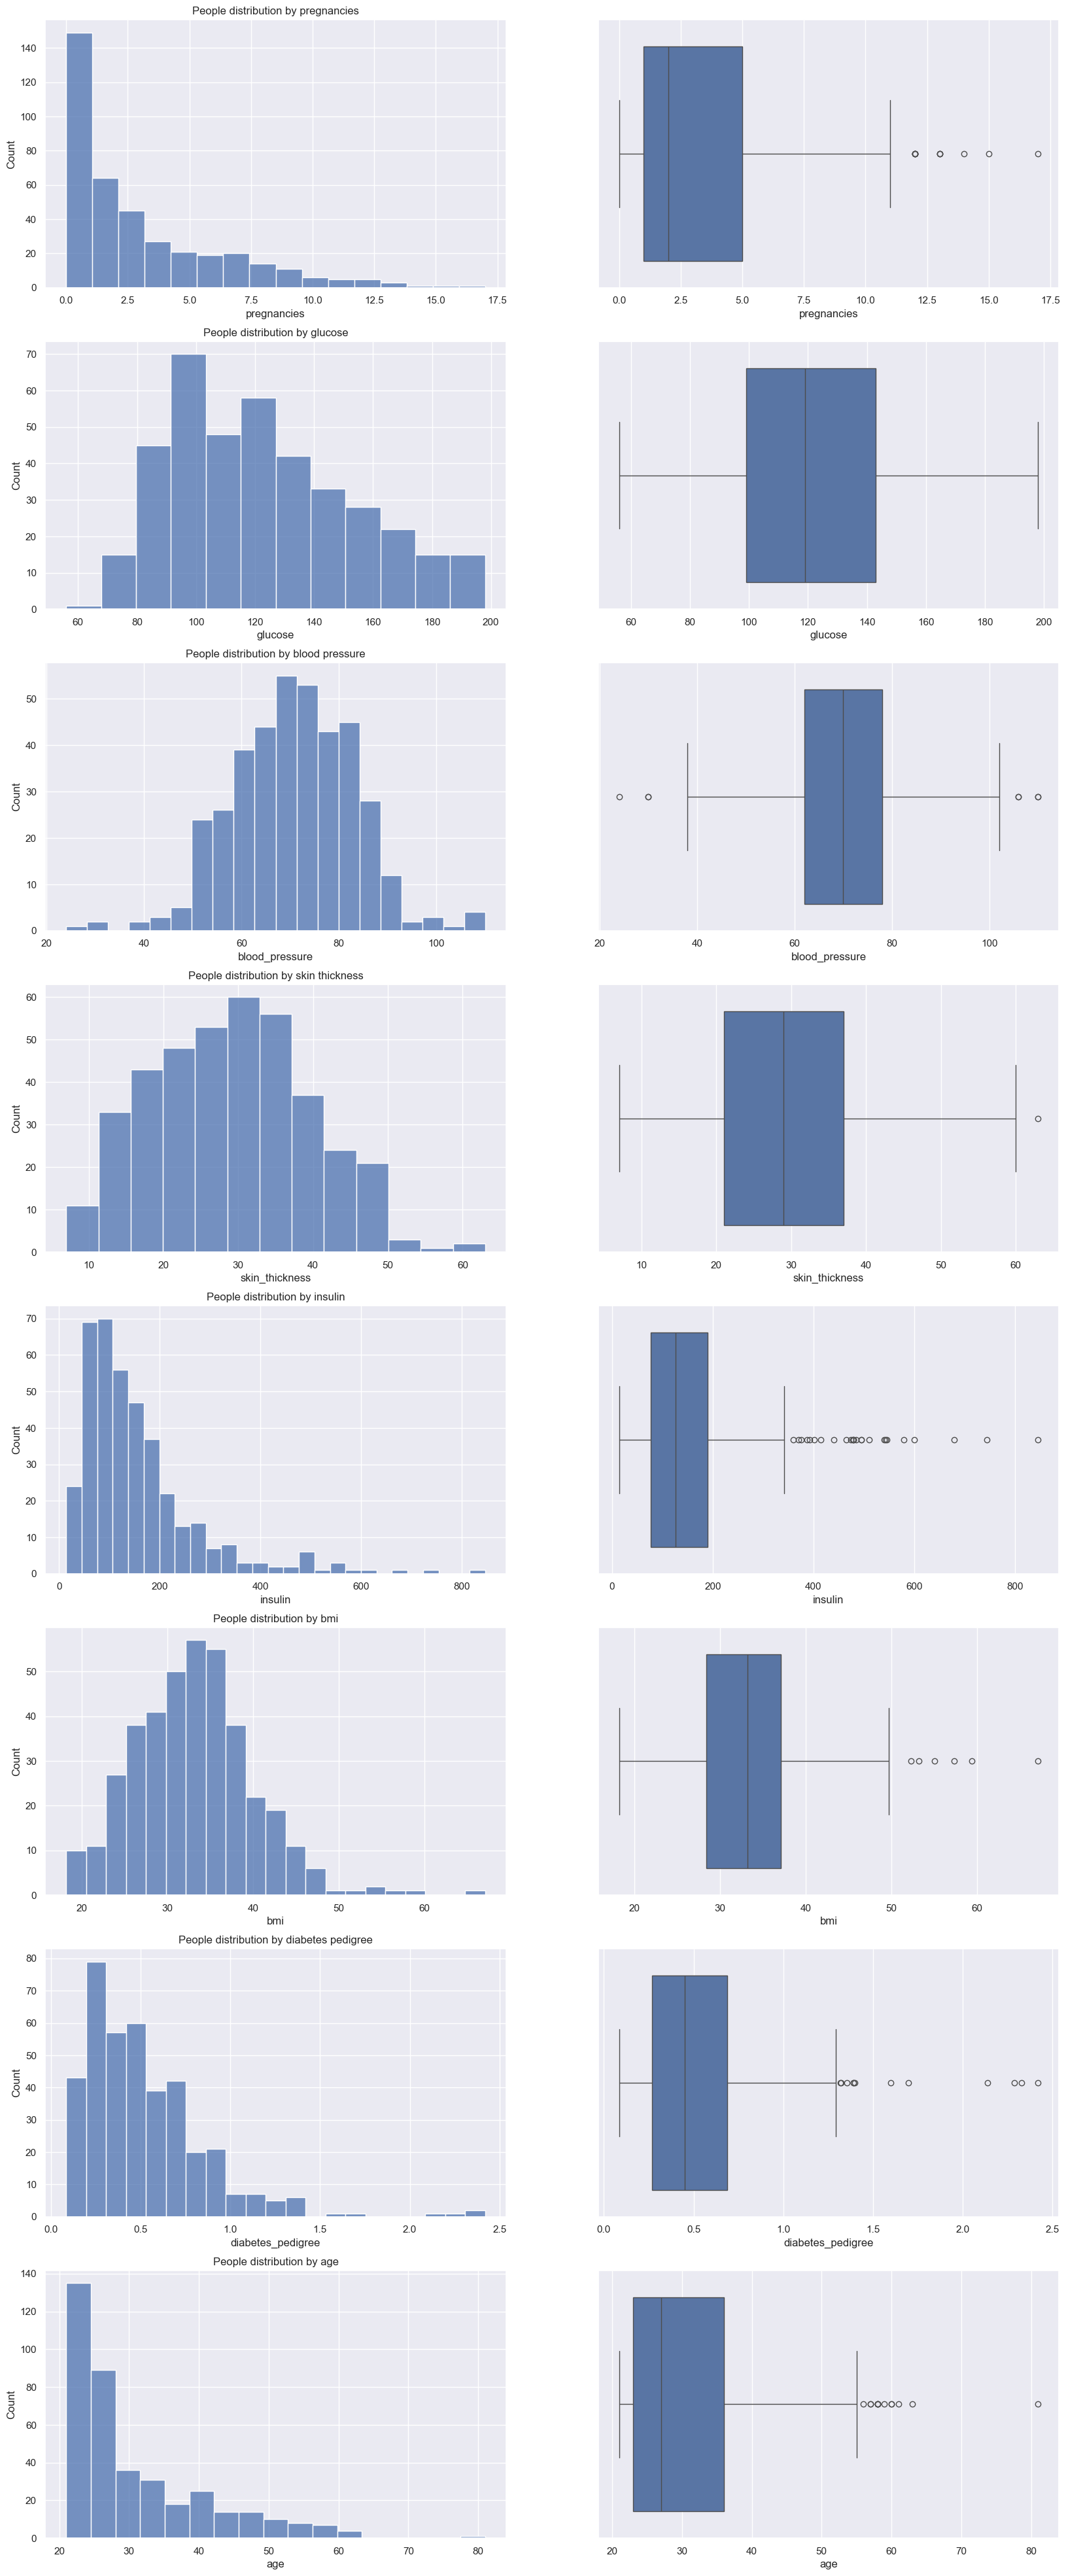

In [182]:
# Plotting explanatory variables charts
fig_expl, ax_expl = plt.subplots(nrows=8, ncols=2, figsize=(20,50))
for idx, column in enumerate(df.columns[:-1]):
    x = df[column]
    sns.histplot(x=x, ax=ax_expl[idx, 0], binrange=[np.min(x), np.max(x)])
    sns.boxplot(x=x, ax=ax_expl[idx, 1])

ax_expl[0][0].set_title("People distribution by pregnancies")
ax_expl[1][0].set_title("People distribution by glucose")
ax_expl[2][0].set_title("People distribution by blood pressure")
ax_expl[3][0].set_title("People distribution by skin thickness")
ax_expl[4][0].set_title("People distribution by insulin")
ax_expl[5][0].set_title("People distribution by bmi")
ax_expl[6][0].set_title("People distribution by diabetes pedigree")
ax_expl[7][0].set_title("People distribution by age");

From a first sight at data, it is possible to notice that there are some variables whose distribution appears to be right-skewed, like `pregnancies`, `insulin`, `diabetes_pedigree` and `age`, while the remaining ones appear to have a more normal-looking distribution.

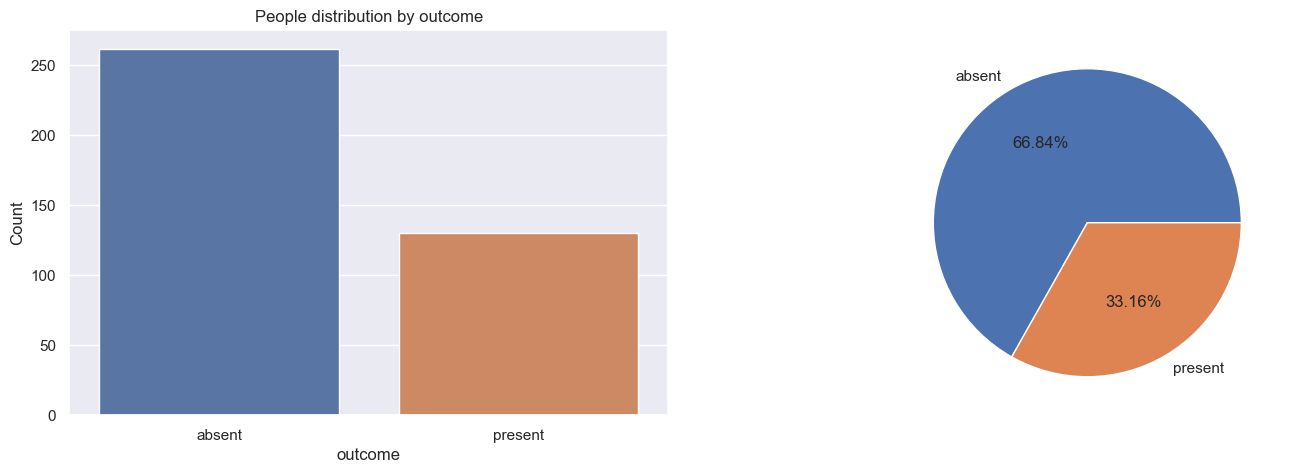

In [183]:
# Plotting response variable charts
fig_resp, ax_resp = plt.subplots(nrows=1, ncols=2, figsize=(17,5))
sns.barplot(x=df['outcome'].value_counts().sort_index().index, 
            y=df['outcome'].value_counts().sort_index().values,
            ax=ax_resp[0],
            hue=df['outcome'].value_counts().sort_index().index)
ax_resp[0].set_ylabel("Count")
ax_resp[1] = plt.pie(x=df['outcome'].value_counts().sort_index().values, 
                     labels=['absent', 'present'],
                     autopct="%.2f%%")
ax_resp[0].set_title("People distribution by outcome");

### Bivariate analysis

#### Numerical variables correlation
Both a correlation matrix and a pairplot can be employed to have at a glance the, respectively, the linear correlation between variables and the scatterplot of the variables pair by pair.

##### Heatmap

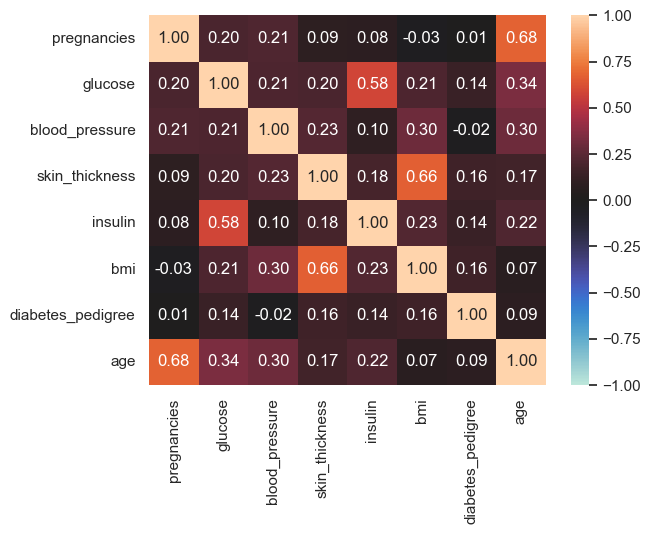

In [184]:
corr_matrix = df_numeric.corr()
sns.heatmap(data = corr_matrix,
            vmin = -1,
            vmax = 1,
            annot = True,
            fmt = '.2f',
            cmap = 'icefire');

There are some expected positive linear correlation due to the nature of the human body between some variable pairs like:
- `Age`-`Pregnancies`(**0.68**): as a woman ages, the amount of children she can give birth to naturally increases.
- `BMI`-`Skin thickness`(**0.66**): BMI is used to describe the body mass relative to height and skin thickness is used as a measure of subcutaneous fat. As a person's body fat increases, both measures will naturally increase
- `Glucose`-`Insulin`(**0.58**): when glucose in bloodstream rises, the pancreases produces insulin. It is expected to find higher insulin leves in patients with higher sugar levels.
- `Age`-`Glucose`(0.34): as a person ages, their insulin sensitivity can increase therefore letting more glucose in the bloodstream than it should be.
- `Age`-`Blood pressure`(0.30): as a person ages, the quality of their cardiovascular system decreases and can cause increase in the systolic blood pressure.
- `BMI`-`Blood pressure`(0.30): a higher BMI implies that, unless the patient has a higher amount of muscle mass due to physical exercise, a higher amount of fat tissue is present that can interfere with the body blood pressure management. 

On the other hand, there are also some close-to-absent correlations between variable pairs like:
- `Pregnancies`-`Skin thickness`
- `Pregnancies`-`Insulin`
- `Pregnancies`-`BMI`
- `Pregnancies`-`Diabetes pedigree`
- `Diabetes pedigree`-`Blood pressure`
- `Age`-`BMI`
- `Age`-`Diabetes pedigree`

##### Pairplot

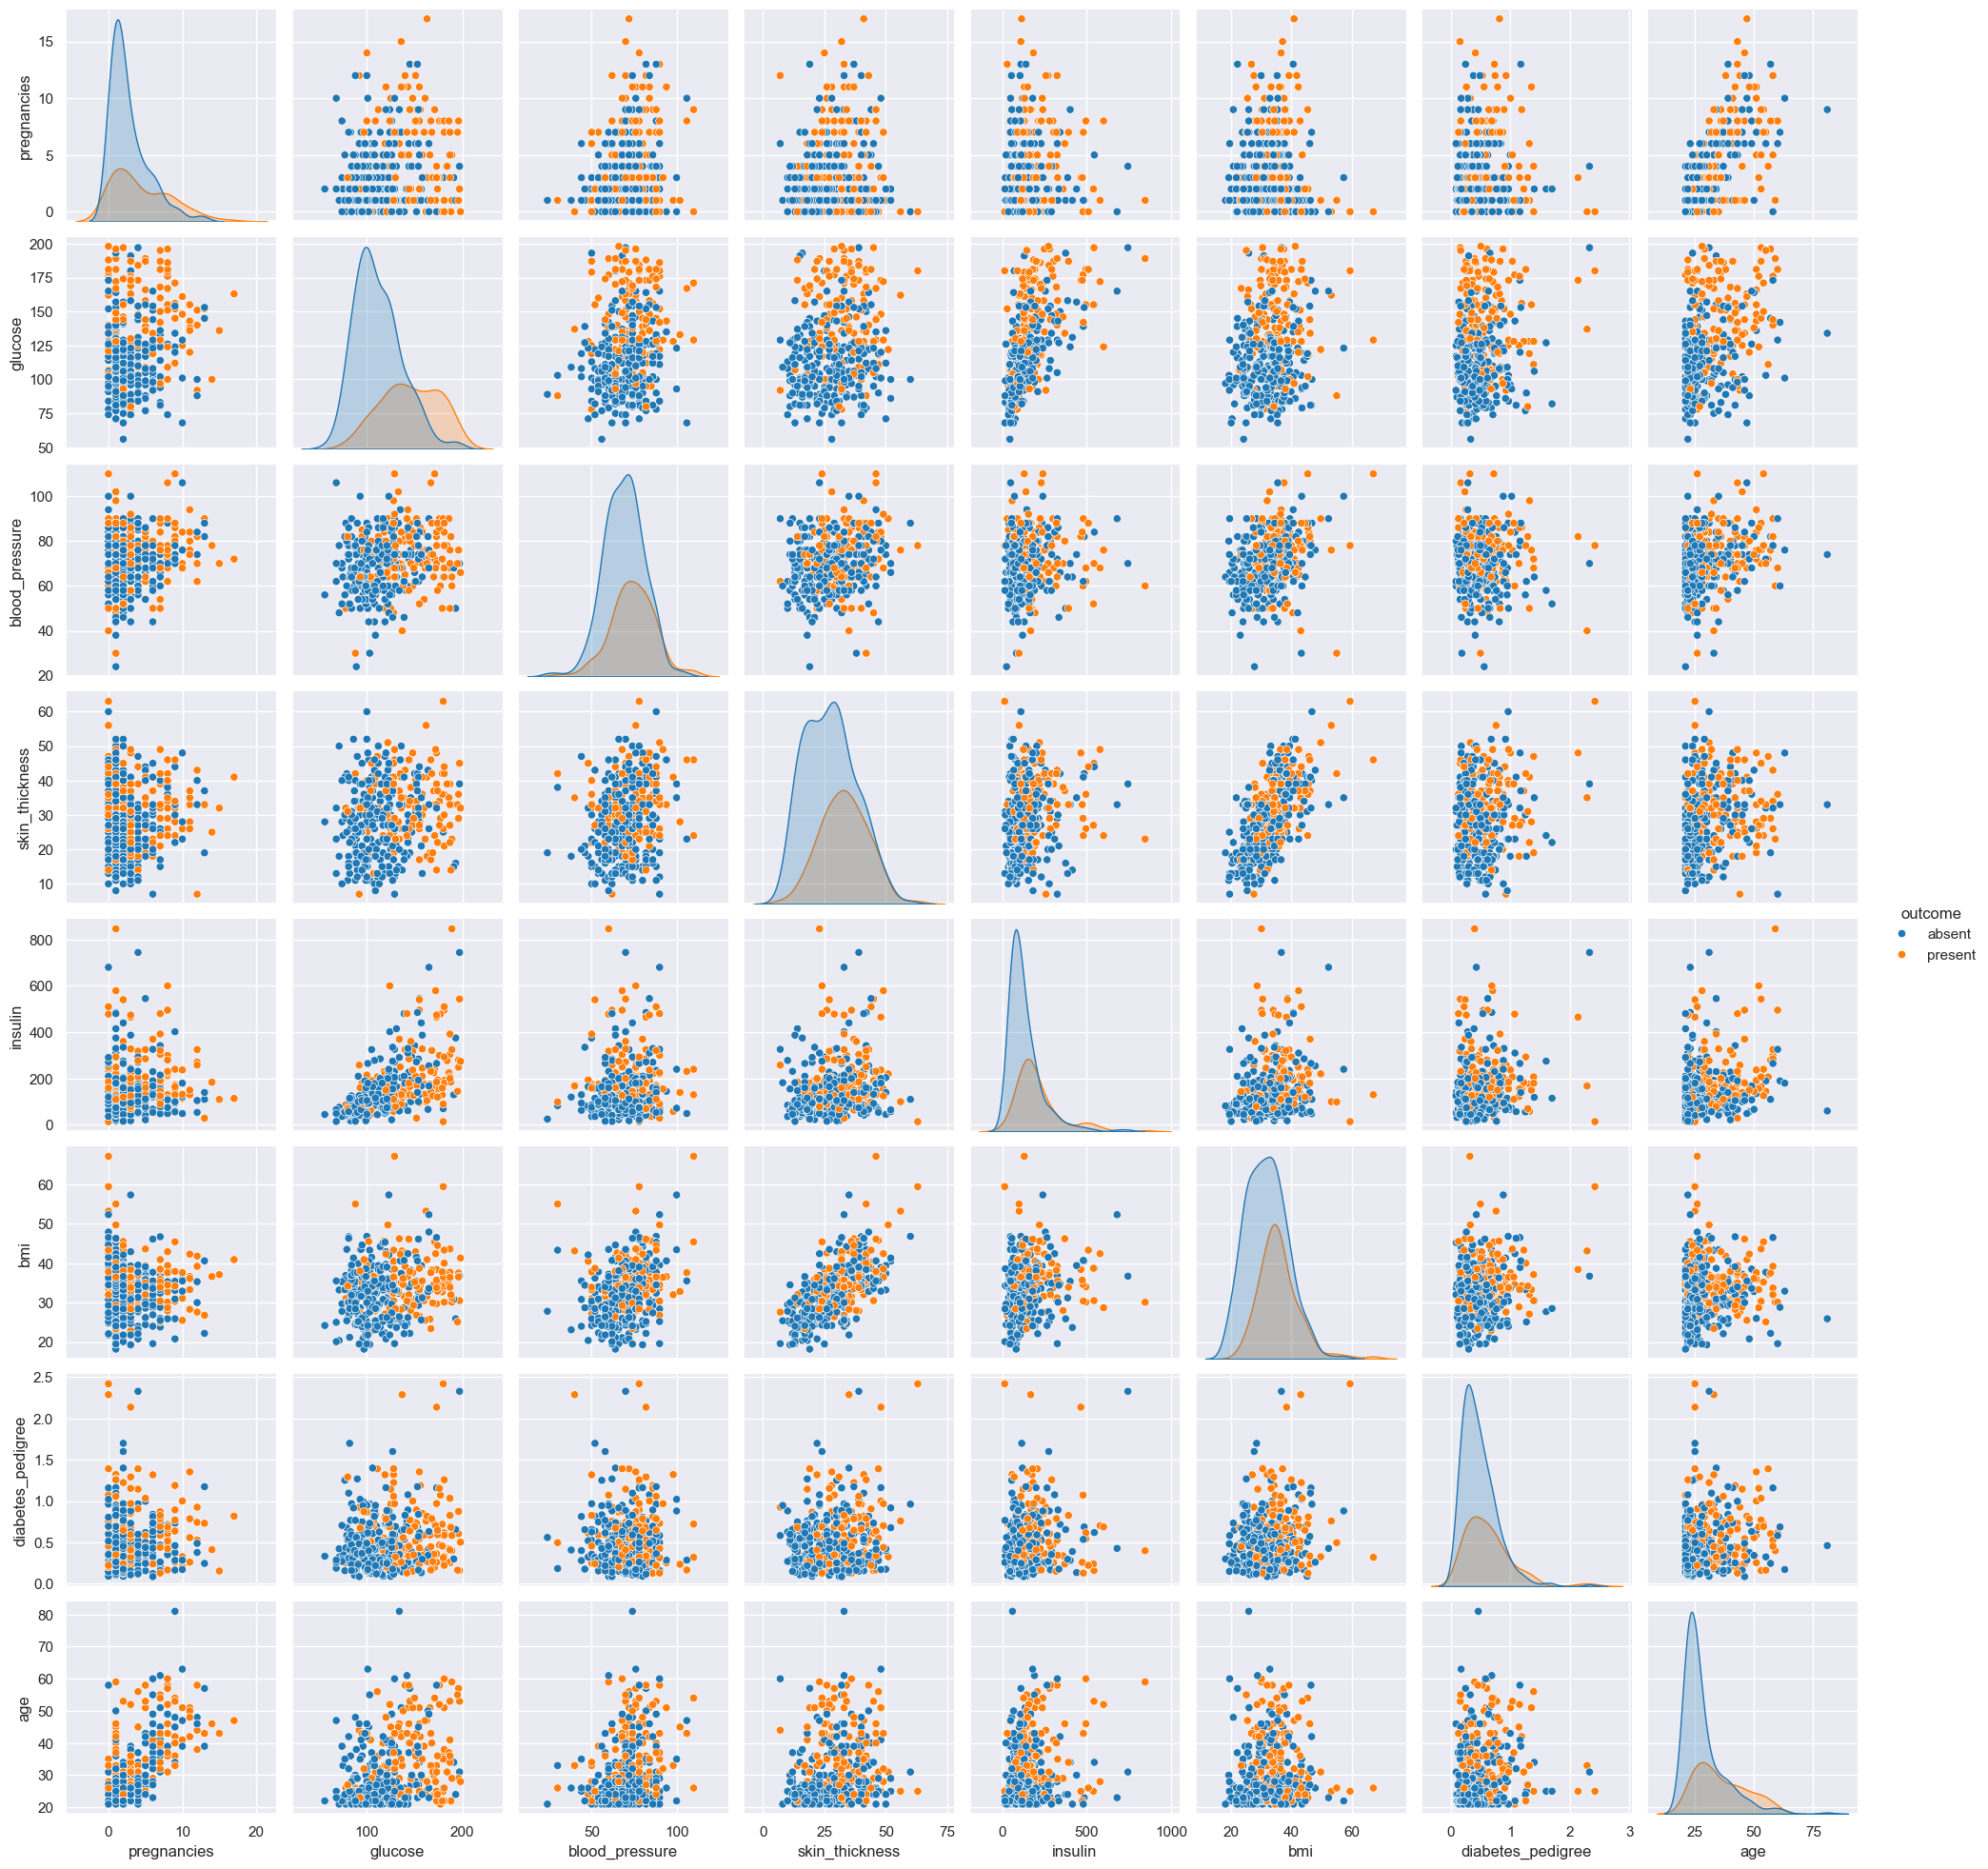

In [185]:
sns.pairplot(data = df, hue = 'outcome', palette='tab10');

It is possible to notice that in the `Glucose` row and column of the whole pairplot, the variable seems to be a good indicator of people having diabetes or not. The `Glucose` axis (both vertically when it is on the Y axis and horizontally when it is on the X axis) shows a separation of the patients having diabetes or not.

Also in the `Glucose`-`Glucose` plot itself it is noticeable that the two distribution are not as overlapping as in the other same-variable-plot, pointing at the fact that it could be a possible discriminating factor.

#### Categorical variables association with numerical variables

In [186]:
warnings.filterwarnings('ignore')

# Calculating ŋ² coefficient for each of the combinations of two variables
eta_squared_num_var = []
eta_squared_cat_var = []
eta_squared_value = []

for num_var in df.columns[:-1]:     
    eta_squared_num_var.append(num_var)
    eta_squared_cat_var.append('outcome')
    eta = calculate_eta_squared(df, num_var, 'outcome')         
    eta_squared_value.append(eta)

# Generating the eta squared dataframe and sorting by eta_squared value
eta_squared_df = pd.DataFrame({'variable1': eta_squared_num_var, 'variable2': eta_squared_cat_var, 'eta_squared': eta_squared_value})
eta_squared_df = eta_squared_df.sort_values(by='eta_squared', ascending=False)  
eta_squared_df = eta_squared_df.reset_index(drop=True)
eta_squared_df.head(10)

variable1 variable2  eta_squared
0            glucose   outcome     0.265949
1                age   outcome     0.123063
2            insulin   outcome     0.090860
3                bmi   outcome     0.072964
4        pregnancies   outcome     0.065826
5     skin_thickness   outcome     0.065503
6  diabetes_pedigree   outcome     0.043819
7     blood_pressure   outcome     0.037123

What was noticeable in the previous pairplot is also now showed through the ŋ² coefficient. `Glucose` is the explanatory variable that has the highest association with the response variable.

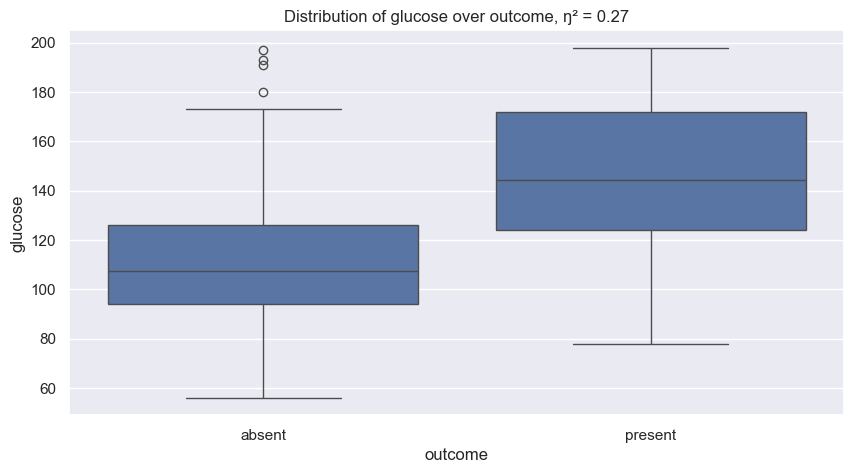

In [187]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df, x = 'outcome', y = 'glucose')
plt.title(f"Distribution of glucose over outcome, ŋ² = {eta_squared_df.loc[0, 'eta_squared']:.2f}");

## Unsupervised analysis

### Encoding

In [188]:
df_encoded = df.copy()

# Categorical variables
df_encoded['outcome'] = df_encoded['outcome'].map({'absent': 0, 'present': 1})
df_encoded

pregnancies  glucose  blood_pressure  skin_thickness  insulin   bmi  \
0              1       89              66              23       94  28.1   
1              0      137              40              35      168  43.1   
2              3       78              50              32       88  31.0   
3              2      197              70              45      543  30.5   
4              1      189              60              23      846  30.1   
..           ...      ...             ...             ...      ...   ...   
387            0      181              88              44      510  43.3   
388            1      128              88              39      110  36.5   
389            2       88              58              26       16  28.4   
390           10      101              76              48      180  32.9   
391            5      121              72              23      112  26.2   

     diabetes_pedigree  age outcome  
0                0.167   21       0  
1                2.288   33       1  
2                0.248   26       1  
3                0.158   53       1  
4                0.398   59       1  
..                 ...  ...     ...  
387              0.222   26       1  
388              1.057   37       1  
389              0.766   22       0  
390              0.171   63       0  
391              0.245   30       0  

[392 rows x 9 columns]

### Scaling

In [189]:
scaler = StandardScaler(with_std=True, with_mean=True)
df_scaled = scaler.fit_transform(df_encoded)

df_scaled = pd.DataFrame(df_scaled, columns=df_encoded.columns)

# The response variable, Outcome, is not taken into account for applying PCA
df_scaled = df_scaled[df_scaled.columns[:-1]]

In [190]:
df_scaled.describe()

pregnancies       glucose  blood_pressure  skin_thickness  \
count  3.920000e+02  3.920000e+02    3.920000e+02    3.920000e+02   
mean  -9.063045e-18  1.132881e-17   -4.531523e-16    1.087565e-16   
std    1.001278e+00  1.001278e+00    1.001278e+00    1.001278e+00   
min   -1.029213e+00 -2.161731e+00   -3.739001e+00   -2.108484e+00   
25%   -7.174265e-01 -7.665958e-01   -6.941640e-01   -7.755315e-01   
50%   -4.056403e-01 -1.176959e-01   -5.314565e-02   -1.384444e-02   
75%    5.297185e-01  6.609841e-01    5.878727e-01    7.478426e-01   
max    4.271153e+00  2.445459e+00    3.151946e+00    3.223325e+00   

            insulin           bmi  diabetes_pedigree           age  
count  3.920000e+02  3.920000e+02       3.920000e+02  3.920000e+02  
mean   1.064908e-16  1.631348e-16       1.812609e-17  1.110223e-16  
std    1.001278e+00  1.001278e+00       1.001278e+00  1.001278e+00  
min   -1.196867e+00 -2.120941e+00      -1.269525e+00 -9.682991e-01  
25%   -6.681786e-01 -6.676780e-01      -7.340909e-01 -7.719850e-01  
50%   -2.574448e-01  1.621036e-02      -2.131475e-01 -3.793569e-01  
75%    2.859877e-01  5.718696e-01       4.751644e-01  5.040564e-01  
max    5.812990e+00  4.846172e+00       5.497667e+00  4.921123e+00

In [191]:
df_scaled

pregnancies   glucose  blood_pressure  skin_thickness   insulin  \
0      -0.717427 -1.091046       -0.373655       -0.585110 -0.522842   
1      -1.029213  0.466314       -2.456964        0.557421  0.100631   
2      -0.093854 -1.447941       -1.655691        0.271788 -0.573394   
3      -0.405640  2.413014       -0.053146        1.509530  3.260122   
4      -0.717427  2.153454       -0.854419       -0.585110  5.812990   
..           ...       ...             ...             ...       ...   
387    -1.029213  1.893894        1.389146        1.414319  2.982087   
388    -0.717427  0.174309        1.389146        0.938264 -0.388037   
389    -0.405640 -1.123491       -1.014673       -0.299477 -1.180016   
390     2.088650 -0.701706        0.427618        1.795162  0.201735   
391     0.529718 -0.052806        0.107109       -0.585110 -0.371186   

          bmi  diabetes_pedigree       age  
0   -0.710421          -1.031876 -0.968299  
1    1.426730           5.115111  0.209585  
2   -0.297238          -0.797126 -0.477514  
3   -0.368477          -1.057960  2.172726  
4   -0.425468          -0.362402  2.761668  
..        ...                ...       ...  
387  1.455225          -0.872478 -0.477514  
388  0.486384           1.547482  0.602213  
389 -0.667678           0.704119 -0.870142  
390 -0.026533          -1.020284  3.154296  
391 -0.981127          -0.805820 -0.084886  

[392 rows x 8 columns]

In [192]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        392 non-null    float64
 1   glucose            392 non-null    float64
 2   blood_pressure     392 non-null    float64
 3   skin_thickness     392 non-null    float64
 4   insulin            392 non-null    float64
 5   bmi                392 non-null    float64
 6   diabetes_pedigree  392 non-null    float64
 7   age                392 non-null    float64
dtypes: float64(8)
memory usage: 24.6 KB


### PCA

#### Applying pca

In [193]:
# Fitting PCA
pca = PCA() 
pca.fit(df_scaled)

# Showing PCA loadings
pca.components_ 

array([[ 0.31459005,  0.42433171,  0.32957685,  0.38284835,  0.3648862 ,
         0.3677518 ,  0.16737061,  0.41156493],
       [ 0.5519162 ,  0.04691165,  0.0310265 , -0.41288424, -0.06771988,
        -0.50463924, -0.1882636 ,  0.47651005],
       [-0.21849279,  0.47389479, -0.39071857, -0.30243304,  0.58184163,
        -0.25640534,  0.25560994, -0.1180596 ],
       [ 0.196718  , -0.22732104, -0.30670295,  0.08988925, -0.25475531,
        -0.03239358,  0.84679316,  0.1564357 ],
       [-0.24532769,  0.06218971,  0.77641617, -0.38113858, -0.0743071 ,
        -0.141116  ,  0.38784281, -0.10954803],
       [-0.0963409 ,  0.72284917, -0.09849225,  0.12167773, -0.65952598,
        -0.08110908, -0.02667812, -0.03789978],
       [ 0.19533896,  0.08289322, -0.14536547, -0.64193671, -0.11876492,
         0.71083263, -0.00727993, -0.04812913],
       [-0.63431852, -0.09077998, -0.10017407, -0.10608061, -0.06504585,
         0.1073749 , -0.05442457,  0.7412076 ]])

In [194]:
# Applying fitted PCA to the scaled dataset
scores = pca.transform(df_scaled)

# Creating new dataset out of the PCA scores
df_pca = pd.DataFrame(scores)
df_pca

0         1         2         3         4         5         6  \
0   -2.059077 -0.090379 -0.308834 -0.700160 -0.113979 -0.287260 -0.189441   
1    0.781519 -2.442463  2.212718  4.787571 -0.086500  0.419553  0.791828   
2   -1.734034 -0.171954 -0.505743  0.248924 -1.628413 -0.399817 -0.186551   
3    3.227925  0.464083  2.260795 -1.850913 -1.205616 -0.202134 -1.586495   
4    3.223042  1.125378  4.760714 -1.763163 -0.945446 -2.255609 -0.584922   
..        ...       ...       ...       ...       ...       ...       ...   
387  2.759888 -2.019638  1.347216 -2.552260  0.196759 -0.539996 -0.444303   
388  1.209445 -0.955621 -0.613203  0.965233  1.402197  0.324825 -0.578359   
389 -1.969793 -0.314761 -0.189442  1.242245 -0.093708  0.137063 -0.130333   
390  2.378805  2.086779 -2.007893  0.179543 -1.660741 -0.755361 -1.051919   
391 -0.710529  1.166298 -0.166017 -0.538535  0.035732  0.178152 -0.184250   

            7  
0   -0.050203  
1    0.821117  
2    0.022830  
3    1.299841  
4    2.050143  
..        ...  
387 -0.152438  
388  0.640175  
389 -0.185506  
390  0.883109  
391 -0.380143  

[392 rows x 8 columns]

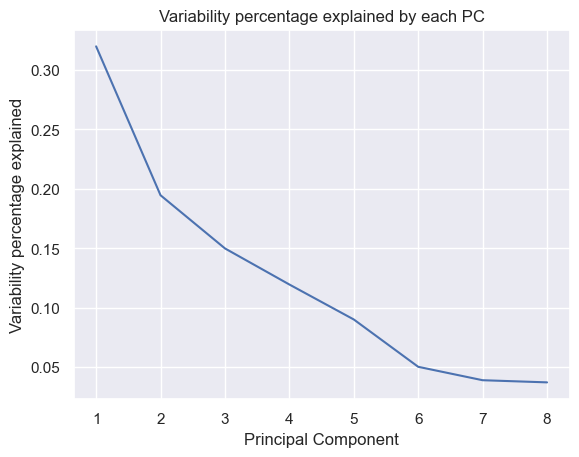

In [195]:
# Showing the variation explained by each Principal Component
sing_var_expl = sns.lineplot(pca.explained_variance_ratio_)
sing_var_expl.set_xticks(np.arange(0,8), labels=np.arange(1,9))
plt.xlabel("Principal Component")
plt.ylabel("Variability percentage explained")
plt.title("Variability percentage explained by each PC");

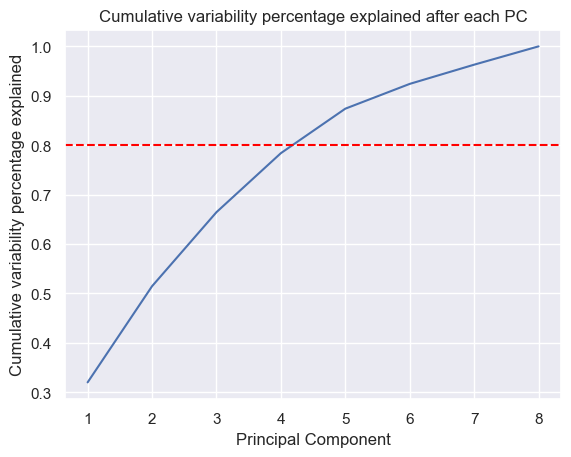

In [196]:
# Showing the cumulative variance explained by the Principal Components
cum_var_expl = sns.lineplot(pca.explained_variance_ratio_.cumsum())
cum_var_expl.set_xticks(np.arange(0,8), labels=np.arange(1,9))
cum_var_expl.axhline(0.8, color = 'red', linestyle = '--')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative variability percentage explained")
plt.title("Cumulative variability percentage explained after each PC");

In [197]:
expl_var = pd.DataFrame({'individual_explained_var': pca.explained_variance_ratio_,
                         'cumulative_explained_var': pca.explained_variance_ratio_.cumsum()},
                        index = np.arange(1,9))
expl_var

individual_explained_var  cumulative_explained_var
1                  0.319940                  0.319940
2                  0.194598                  0.514538
3                  0.149845                  0.664383
4                  0.119462                  0.783845
5                  0.090022                  0.873867
6                  0.050178                  0.924045
7                  0.038884                  0.962929
8                  0.037071                  1.000000

It is possible to notice that 4 Principal Components are enough to explain ~80% of the variance.

#### Correlation circles

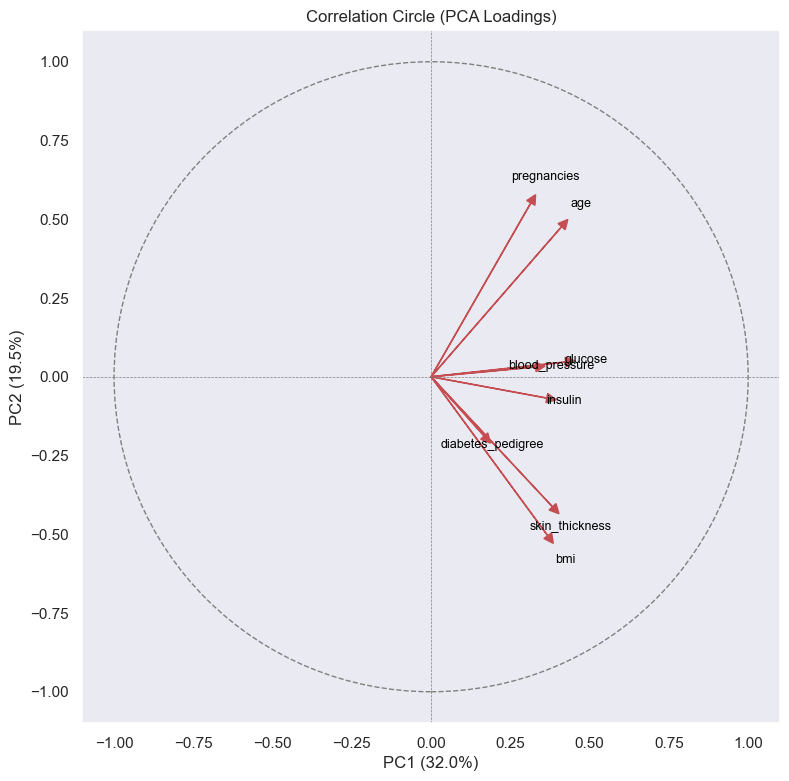

In [198]:
# PC1 and PC2
correlation_circle_graph(pca, df_scaled.columns, components=(0, 1))

By looking at the First Principal Component, it is possible to notice that there are several variables that look highly correlated since the angle between them is quite small. Such pairs are:
- `Pregnancies`-`Age`
- `Skin thickness`-`BMI`
- `Glucose`-`Insulin`

This finding was to be expected since these variables pairs showed a high linear correlation in the bivariate data exploration.

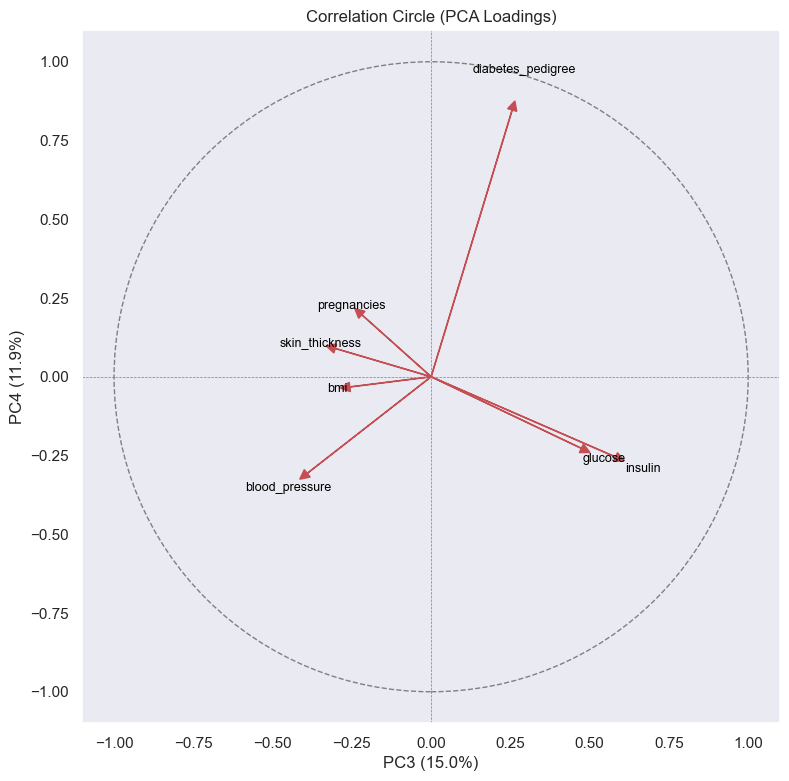

In [199]:
# PC3 and PC4
correlation_circle_graph(pca, df_scaled.columns, components=(2, 3))

#### Biplot

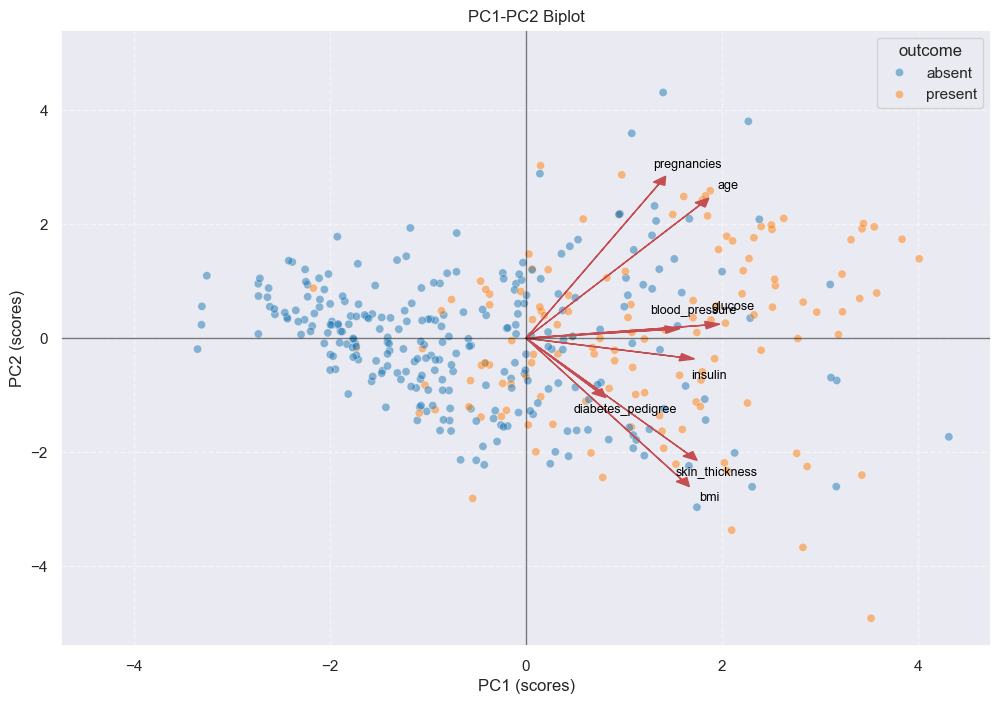

In [200]:
# Biplot plotted over PC1 and PC2
biplot(scores, (0,1), pca, columns=df_scaled.columns, hue=df['outcome'])

By looking at the biplot, it is possible to notice that there is an area, on the negative axis of PC1, that is mostly composed by patients without diabetes while on the positive side of the PC1 axis there are most of the patients with diabites but also quite a lot of patients without diabetes.  
There isn't a clear linear division between the two classes but looking at the variable's arrows it is possible to notice that individuals affected by diabetes tend to have higher values of `Glucose`, `Age` and `BMI`.

While First and Second Principal Component still provide some interpretation, in Third and Fourth Principal Component interpretation is not really clear
- PC1: Diabetes factors, where on positive values there are individuals with higher than average diabetes associated body parameter and on negative values individuals with lower than average diabetes associated body parameter
- PC2: Life stage vs Body composition, where positive there are older individuals with higher number of pregnancies and on negative values there are individuals with higher than average values of BMI and skin thickness

### Clustering

In [201]:
df_clustering = pd.DataFrame(scores[:,:4], columns=[f"PC{i}" for i in np.arange(1,5)])
df_clustering.head()

PC1       PC2       PC3       PC4
0 -2.059077 -0.090379 -0.308834 -0.700160
1  0.781519 -2.442463  2.212718  4.787571
2 -1.734034 -0.171954 -0.505743  0.248924
3  3.227925  0.464083  2.260795 -1.850913
4  3.223042  1.125378  4.760714 -1.763163

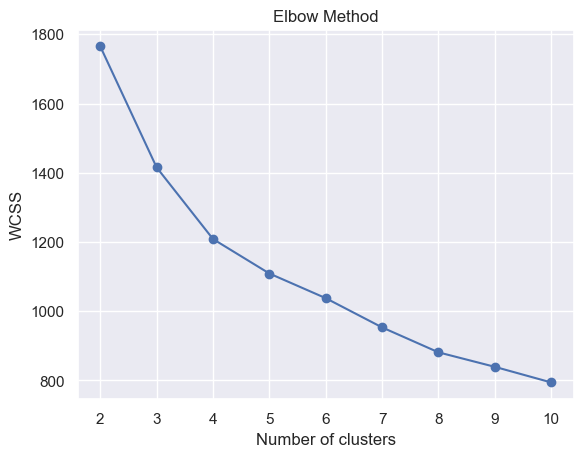

In [202]:
warnings.filterwarnings('ignore')

wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_clustering) 
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method');

Number of clusters 2 has silhouette score of 0.29519353218169764
Number of clusters 3 has silhouette score of 0.27431468945906445
Number of clusters 4 has silhouette score of 0.2699609876035717
Number of clusters 5 has silhouette score of 0.2681971220011139
Number of clusters 6 has silhouette score of 0.25329181157268166
Number of clusters 7 has silhouette score of 0.22169553109424892
Number of clusters 8 has silhouette score of 0.22017423297481634
Number of clusters 9 has silhouette score of 0.21589041109585996
Number of clusters 10 has silhouette score of 0.2056203808256271


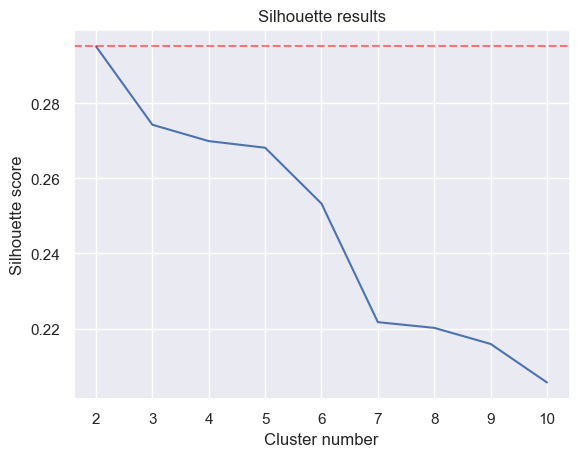

In [203]:
warnings.filterwarnings('ignore')

silhouette_values = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(df_clustering)
    silhouette = silhouette_score(df_clustering, labels)
    silhouette_values.append(silhouette)
    print(f"Number of clusters {i} has silhouette score of {silhouette}")

sns.lineplot(x=range(2, 11), y=silhouette_values)
plt.axhline(y=max(silhouette_values), color='red', alpha=0.5, linestyle="--")
plt.xlabel("Cluster number")
plt.ylabel("Silhouette score")
plt.title("Silhouette results");

In [204]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
labels = kmeans.fit_predict(df_clustering)

centroids = kmeans.cluster_centers_.T
centroids

array([[ 1.6604251 , -1.05160257],
       [ 0.18327678, -0.11607529],
       [-0.04006075,  0.02537181],
       [-0.00822771,  0.00521089]])

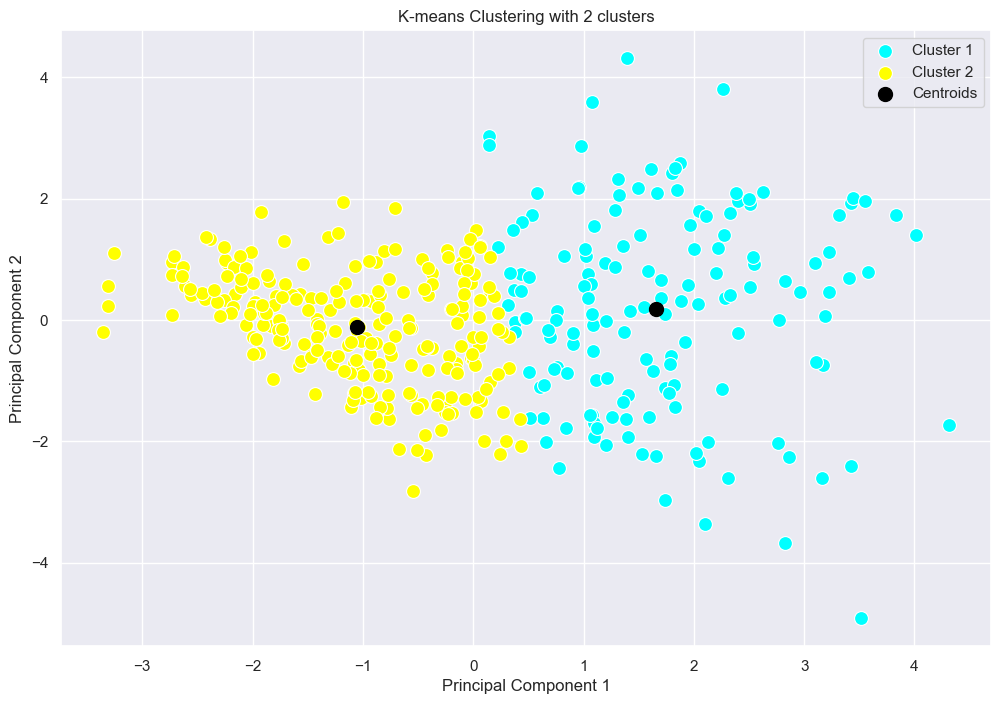

In [205]:
df_clustering["clusters"] = labels

colors = ['cyan', 'yellow', 'magenta']

fig, ax = plt.subplots(figsize=(12, 8))
for k in range(0, 3):
    sns.scatterplot(x=df_clustering['PC1'][df_clustering.clusters == k], y=df_clustering['PC2'][df_clustering.clusters == k], color=colors[k], label='Cluster {}'.format(k+1), s=100)
ax.scatter(centroids[0][:], centroids[1][:], marker='o', s=100, color='black', label='Centroids')
ax.set_title('K-means Clustering with 2 clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend()
plt.show()

K-means provides a similar result also noticeable from the Biplot, not adding much information.

## Supervised analysis

The following models have been chosen to be employed in this analysis:
- SVC
- SVM with RBF kernel
- Logistic regression
- K-NN

SVC and SVM to verify how similar models perform, Logistic regression for its interpretability and K-NN as a mid-way between SVM and Logistic Regression in terms of interpretability.

**Metric employed**  
Recall is going to be the choice since we're interested in not having false negatives being patients classified as not having diabetes when they have diabetes. Also, the classes are imbalanced (138 patients having diabetes while 238 patients don't, with a 36-64 split) therefore Accuracy might not be the ideal metric. 

**Data imbalance**  
To mitigate the data imbalance, the Train and Test split has been stratified.

### Models implementation PCA based

#### Data preprocessing

In [206]:
X = df_pca[[0, 1, 2, 3]]
y = df_encoded['outcome']

X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Support Vector Classifier
A Support Vector Classifier is a hyperplane obtained by solving the following optimization problem $$ y_i(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p) > M(1 - \epsilon_i) \quad \forall i=1, \cdots, n$$ with $$ \epsilon_i \ge 0, \quad \sum_{i=1}^n \epsilon_i \le C $$ where:
- $C$ is interpretable as a budget amount, it is a non-negative value which governs the tradeoff bias-variance
- $\epsilon_1, ..., \epsilon_n$ are slack variables and identify where the observation they are related to is positioned with respect to the margin

In [207]:
# Employing cross-validation in order to find the best value for C
kfold = skm.KFold(10, random_state=42, shuffle=True)
grid_linear = skm.GridSearchCV(SVC(kernel='linear'), {'C': [0.01, 0.1, 1, 5, 10, 100]}, refit=True, cv=kfold, scoring='recall') 
grid_linear.fit(X_train, y_train)

grid_linear.best_params_

{'C': 1}

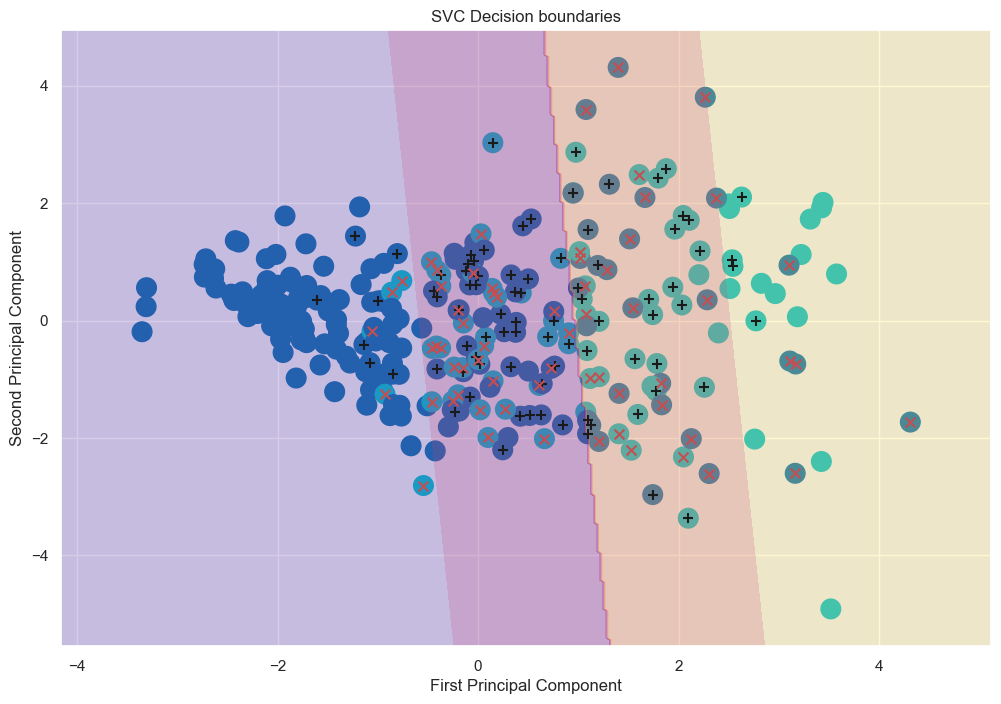

In [208]:
# Fitting the SVC
svm_linear = SVC(kernel='linear', C=grid_linear.best_params_['C'])
svm_linear.fit(X_train, y_train)

# Plotting
fig_linear, ax_linear = plt.subplots(figsize=(12,8))
plot_svm(X_train, y_train, svm_linear, ax=ax_linear)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("SVC Decision boundaries");

**Unexpected black '+' outside of the boundary**  
The reason why there are observations with the black '+' in the correct class part of the plane is because the provided data to the SVC is composed by 4 Principal Components, so it's a 4-dimensional data, but for showcase purpose only 2 dimensions can be showed. Those observations with the black '+' are in the correct 4-dimensional space but when projected into a 2-dimensional space they appear as if they were in the boundary.  

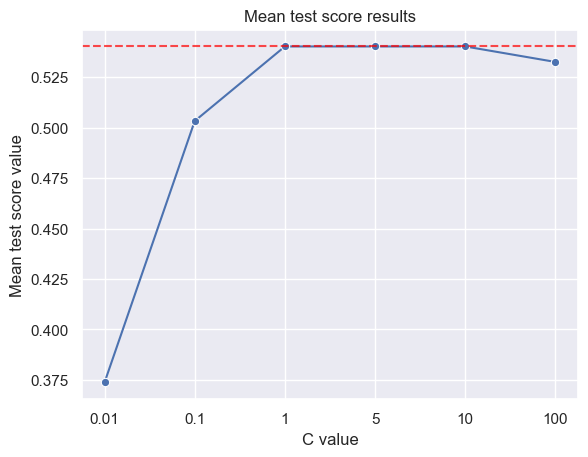

In [209]:
sns.lineplot(x=[1, 2, 3, 4, 5, 6], y=grid_linear.cv_results_['mean_test_score'], marker='o')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6], labels=[0.01, 0.1, 1, 5, 10, 100])
plt.axhline(max(grid_linear.cv_results_['mean_test_score']), color='red', alpha=0.7, linestyle="--")
plt.xlabel("C value")
plt.ylabel("Mean test score value")
plt.title("Mean test score results");

##### Training

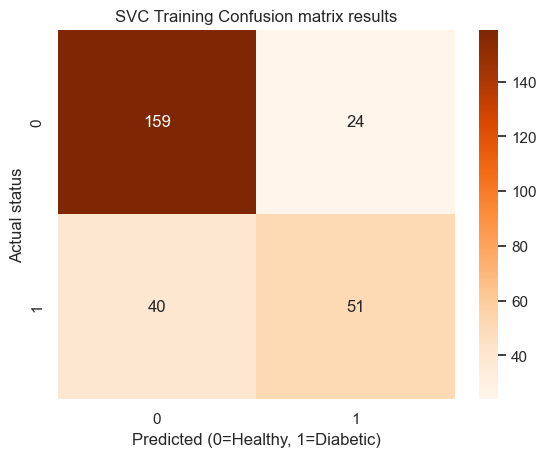

In [210]:
train_pred_svc = svm_linear.predict(X_train)
train_cm_linear = confusion_matrix(y_train, train_pred_svc)
sns.heatmap(train_cm_linear, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("SVC Training Confusion matrix results");

In [211]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_train, train_pred_svc)], 
                   'Recall': [recall_score(y_train, train_pred_svc)], 
                   'Precision': [precision_score(y_train, train_pred_svc)]},
            index=['Values']
)

Accuracy   Recall  Precision
Values  0.766423  0.56044       0.68

##### Testing

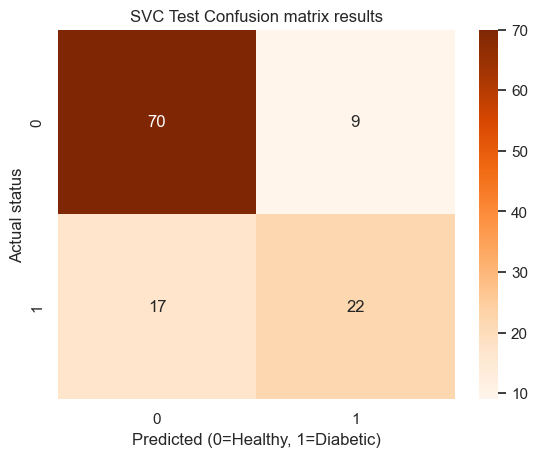

In [212]:
pred_svc = svm_linear.predict(X_test)
cm_linear = confusion_matrix(y_test, pred_svc)
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("SVC Test Confusion matrix results");

In [213]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_test, pred_svc)], 
                   'Recall': [recall_score(y_test, pred_svc)], 
                   'Precision': [precision_score(y_test, pred_svc)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.779661  0.564103   0.709677

#### Support Vector Machine, RBF Kernel
Data is not always linearly separable and in order to solve the problem it is possible to make the boundary more flexible. A Support Vector Machine is an extension of a Support Vector Classifier where different **kernels** can be employed. A kernel is the mathematical expression through which the distance between two points is calculated, $K(x_i, x'_i)$. The kernel employed in this scenario is the Radial Basis Function Kernel: $$ K(x, x') = \exp(-\gamma ||x - x'||^2)$$ 

In [214]:
# Employing cross-validation in order to find the best value for C
kfold = skm.KFold(10, random_state=42, shuffle=True)

# Recall is used since we're interested in not having false negatives being patients classified as not having diabetes when they have diabetes
grid_rbf = skm.GridSearchCV(SVC(kernel='rbf'), {'C': [0.01, 0.1, 1, 5, 10, 100], 'gamma': [0.01, 0.1, 0.5, 1, 2, 3, 4, 5]}, refit=True, cv=kfold, scoring='recall') 

# Fitting the cross-validation
grid_rbf.fit(X_train, y_train)

grid_rbf.best_params_

{'C': 100, 'gamma': 0.1}

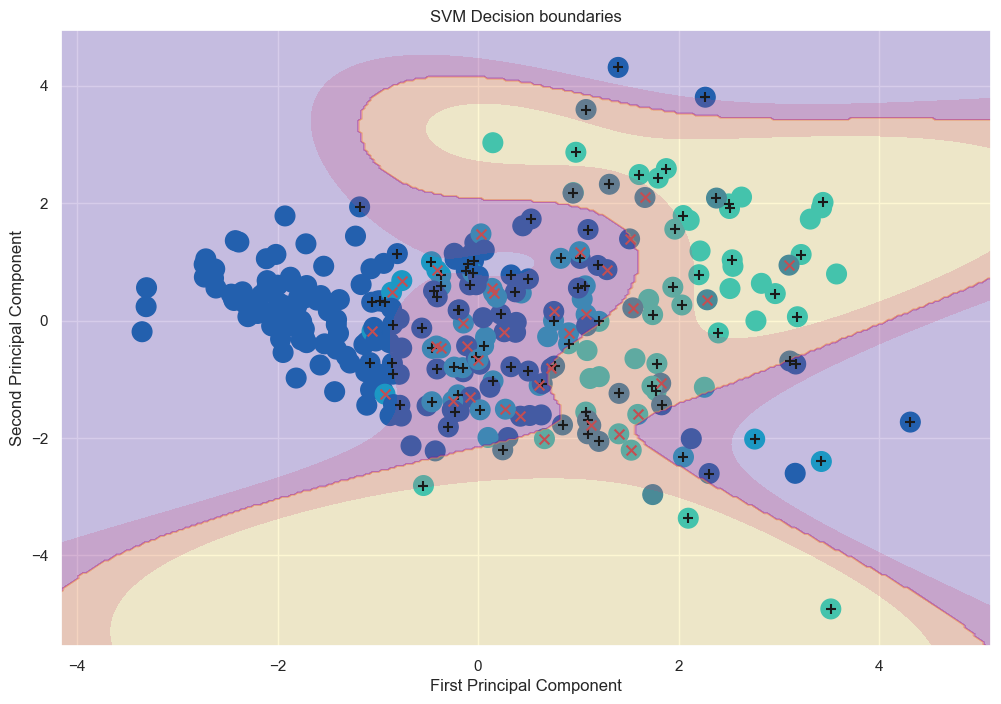

In [215]:
# Fitting the SVM
svm_rbf = SVC(kernel='rbf', C=grid_rbf.best_params_['C'], gamma=grid_rbf.best_params_['gamma'])
svm_rbf.fit(X_train, y_train)

# Plotting
fig_rbf, ax_rbf = plt.subplots(figsize=(12,8))
plot_svm(X_train, y_train, svm_rbf, ax=ax_rbf)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("SVM Decision boundaries");

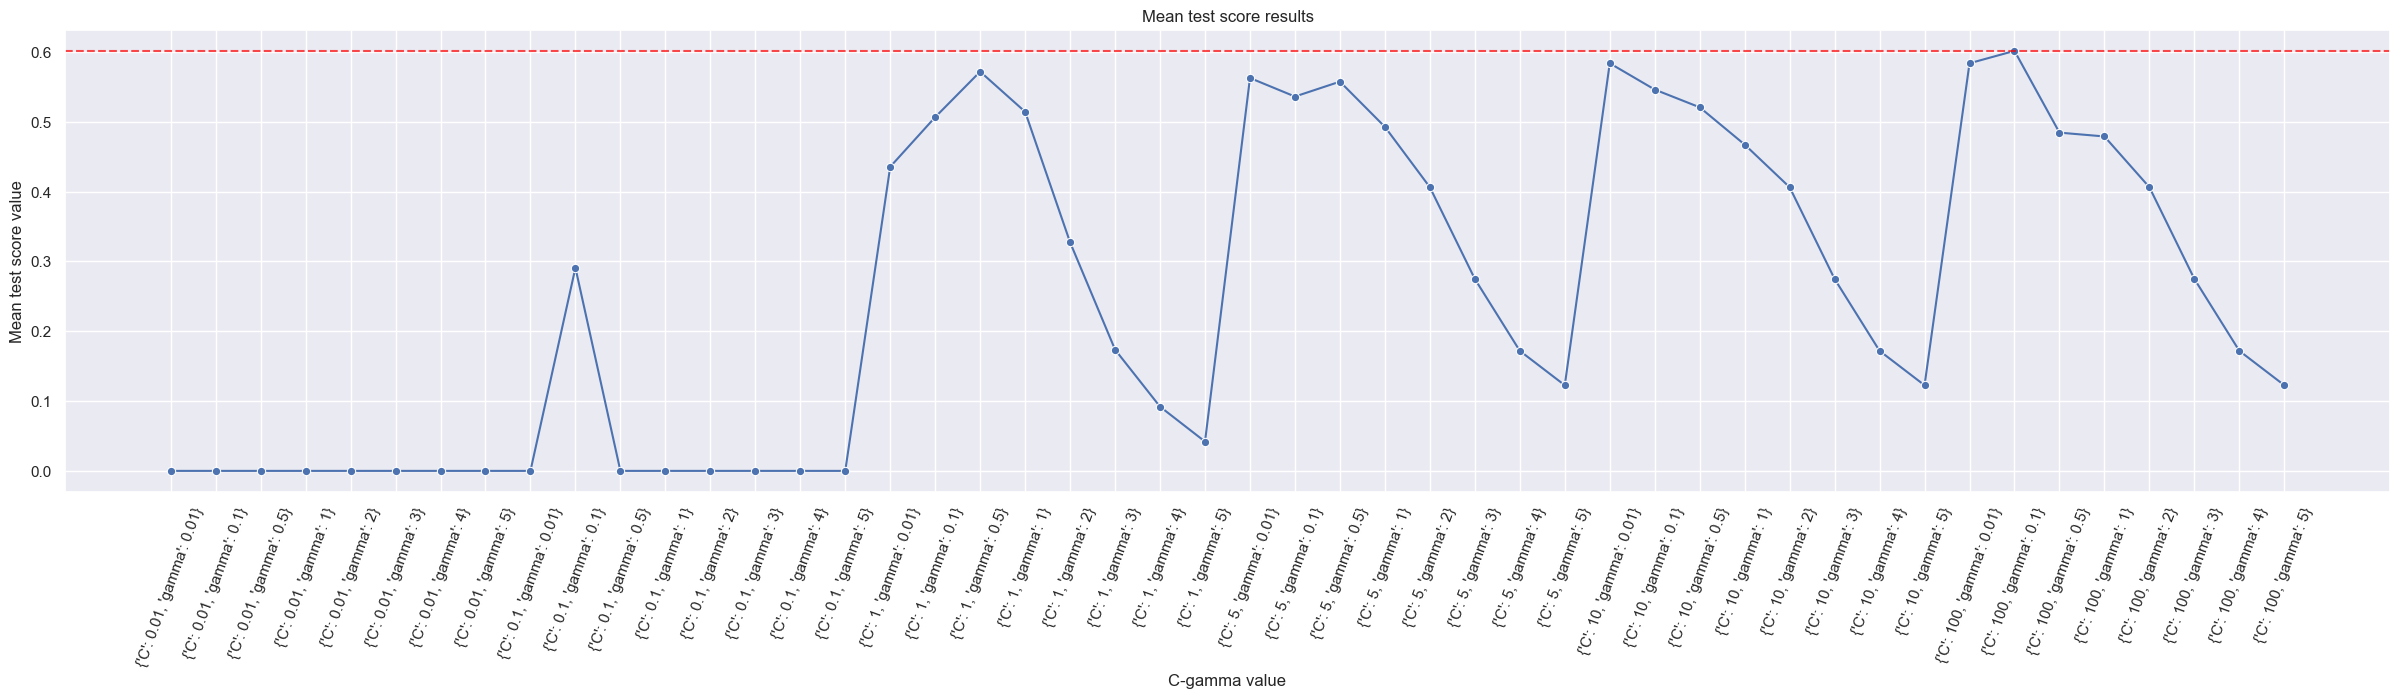

In [216]:
plt.figure(figsize=(30, 6))
sns.lineplot(x=range(0, len(grid_rbf.cv_results_['mean_test_score'])), y=grid_rbf.cv_results_['mean_test_score'], marker='o')
plt.axhline(max(grid_rbf.cv_results_['mean_test_score']), color='red', alpha=0.7, linestyle="--")
plt.xticks(ticks=range(0, len(grid_rbf.cv_results_['mean_test_score'])), labels=grid_rbf.cv_results_['params'], rotation=70)
plt.xlabel("C-gamma value")
plt.ylabel("Mean test score value")
plt.title("Mean test score results");

##### Training

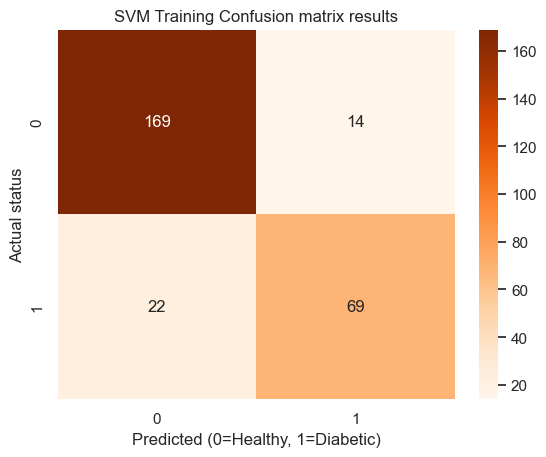

In [217]:
train_pred_svm = svm_rbf.predict(X_train)
train_cm_rbf = confusion_matrix(y_train, train_pred_svm)
sns.heatmap(train_cm_rbf, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("SVM Training Confusion matrix results");

In [218]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_train, train_pred_svm)], 
                   'Recall': [recall_score(y_train, train_pred_svm)], 
                   'Precision': [precision_score(y_train, train_pred_svm)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.868613  0.758242   0.831325

##### Testing

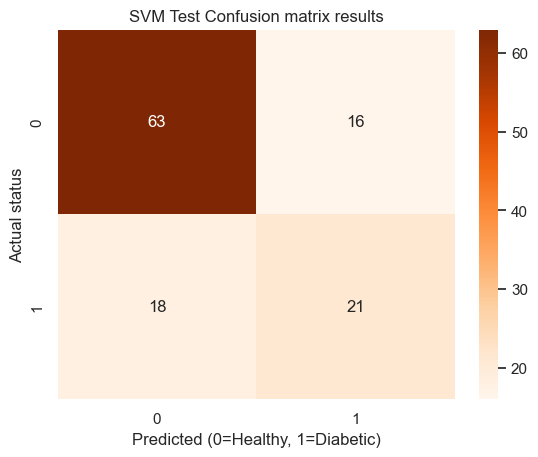

In [219]:
pred_svm = svm_rbf.predict(X_test)
cm_rbf = confusion_matrix(y_test, pred_svm)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("SVM Test Confusion matrix results");

In [220]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_test, pred_svm)], 
                   'Recall': [recall_score(y_test, pred_svm)], 
                   'Precision': [precision_score(y_test, pred_svm)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.711864  0.538462   0.567568

#### Logistic regression
Logistic regression is a model that is able to generate the probability of an observation belonging to a class or the other through a function whose values fall between $0$ and $1$, $$p(X) = \frac{1}{1+ e^{-(\beta_0+\beta_1X_1 + ... + \beta_pX_p)}} $$

In [221]:
# Fitting the Logistic regression
lgs = LogisticRegression()
lgs.fit(X_train, y_train)

LogisticRegression()

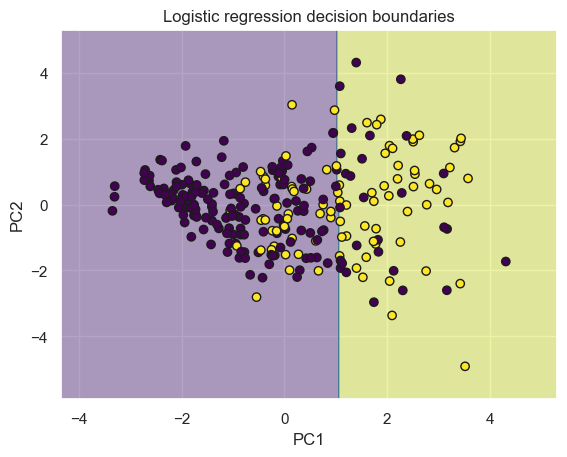

In [222]:
# The decision boundaries are plotted by showing PC1 and PC2, holding PC3 and PC4 values at their mean, being zero
plot_multiclass_decision_boundary(lgs, X_train, y_train)
plt.title("Logistic regression decision boundaries");

It is possible to notice that the decision boundaries of the Logistic regression appear to be somewhat similar to how the Unsupervised analysis result appeared after the clustering.

##### Training

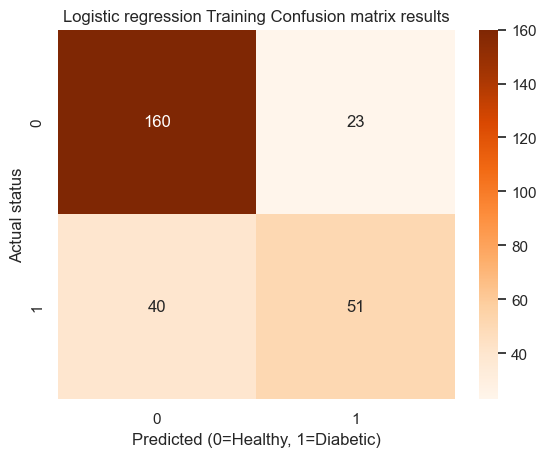

In [223]:
train_pred_lgs = lgs.predict(X_train)
train_cm_lgs = confusion_matrix(y_train, train_pred_lgs)
sns.heatmap(train_cm_lgs, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("Logistic regression Training Confusion matrix results");

In [224]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_train, train_pred_lgs)], 
                   'Recall': [recall_score(y_train, train_pred_lgs)], 
                   'Precision': [precision_score(y_train, train_pred_lgs)]},
            index=['Values']
)

Accuracy   Recall  Precision
Values  0.770073  0.56044   0.689189

##### Testing

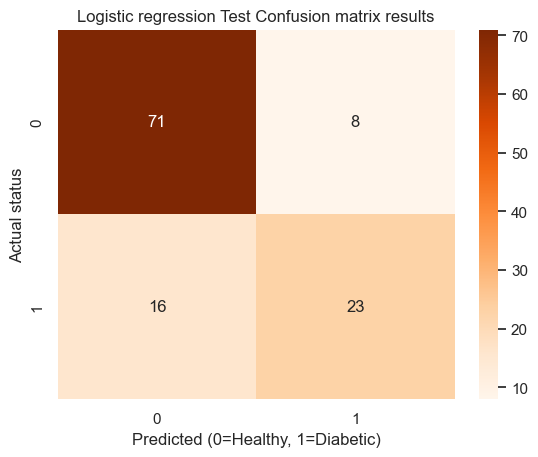

In [225]:
pred_lgs = lgs.predict(X_test)
cm_lgs = confusion_matrix(y_test, pred_lgs)
sns.heatmap(cm_lgs, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("Logistic regression Test Confusion matrix results");

In [226]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_test, pred_lgs)], 
                   'Recall': [recall_score(y_test, pred_lgs)], 
                   'Precision': [precision_score(y_test, pred_lgs)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values   0.79661  0.589744   0.741935

#### K-NN
K-Nearest Neighbor is an algorithm employed for classification purposes that involves a plurality vote of the K nearest neighbors of the observation that needs to be classified. Usually, the distance metric used for this purpose is the Euclidean distance.

In [227]:
grid_knn = skm.GridSearchCV(KNeighborsClassifier(), {'n_neighbors': range(1,20)}, refit=True, cv=kfold, scoring='recall') 

# Fitting the cross-validation
grid_knn.fit(X_train, y_train)

grid_knn.best_params_

{'n_neighbors': 7}

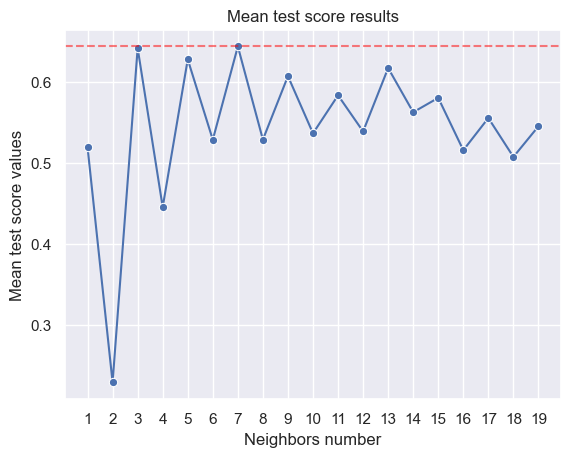

In [228]:
sns.lineplot(x=range(1,20) , y=grid_knn.cv_results_['mean_test_score'], marker='o')
plt.axhline(y=max(grid_knn.cv_results_['mean_test_score']), color='red', alpha=0.5, linestyle="--")
plt.xticks(range(1,20))
plt.xlabel("Neighbors number")
plt.ylabel("Mean test score values")
plt.title("Mean test score results");

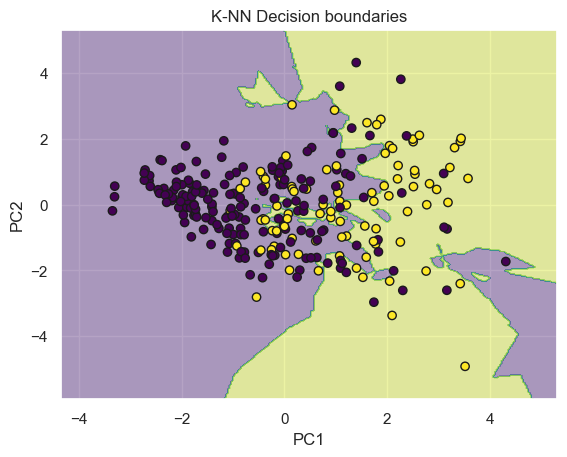

In [229]:
# Fitting the KNN
knn = KNeighborsClassifier(n_neighbors=grid_knn.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

plot_multiclass_decision_boundary(knn, X_train, y_train)
plt.title("K-NN Decision boundaries");

##### Training

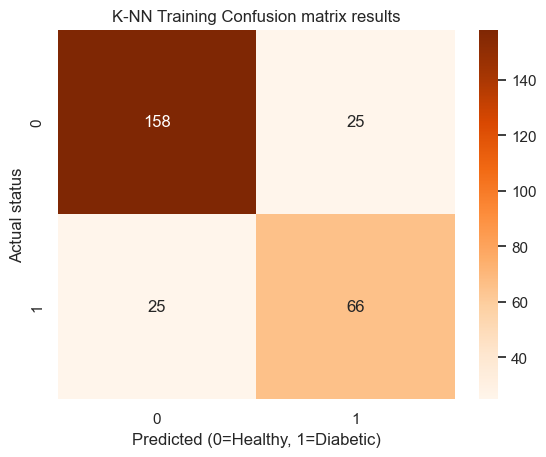

In [230]:
train_pred_knn = knn.predict(X_train)
train_cm_knn = confusion_matrix(y_train, train_pred_knn)
sns.heatmap(train_cm_knn, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("K-NN Training Confusion matrix results");

In [231]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_train, train_pred_knn)], 
                   'Recall': [recall_score(y_train, train_pred_knn)], 
                   'Precision': [precision_score(y_train, train_pred_knn)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.817518  0.725275   0.725275

##### Testing

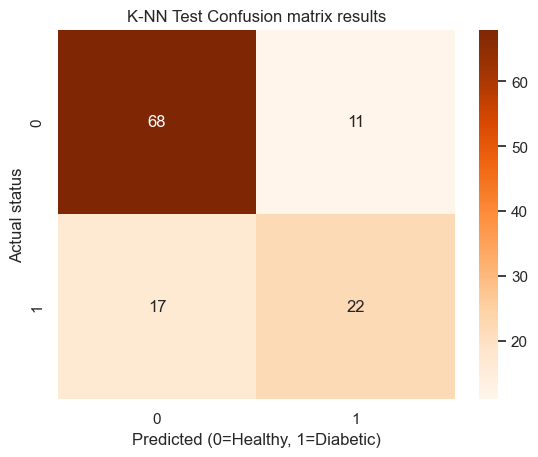

In [232]:
pred_knn = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("K-NN Test Confusion matrix results");

In [233]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_test, pred_knn)], 
                   'Recall': [recall_score(y_test, pred_knn)], 
                   'Precision': [precision_score(y_test, pred_knn)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.762712  0.564103   0.666667

### Models implementation no-PCA based
Although PCA is a really useful tool for the purpose of dimensionality reduction and maximizing variability explained through fewer predictors, employing the four Principal Components that explained ~80% of variability as predictors for previously showed models didn't appear to provide satisfying results so it has been decided to compare the performances of the models on pre-PCA data.

Taking a step back to the Pairplot showed in the Bivariate analysis, it was possible to notice how `Glucose` plots provided a possible path to investigate deeper into in separating patients affected by diabetes and not. For this analysis, the same models will be employed and to plot the 2-dimensional projection of the decision boundareis the pair of variables  used will be `Glucose` and `Age` since they appeared to be the predictors with the strongest association with `Outcome` through the eta squared coefficient.

#### Data preprocessing </a>

In [234]:
X_nopca = df_scaled[df.columns[:-1]]
y_nopca = df_encoded['outcome']

X_nopca_train, X_nopca_test, y_nopca_train, y_nopca_test = skm.train_test_split(X_nopca, y_nopca, test_size=0.3, random_state=42, stratify=y_nopca)
X_nopca_train = X_nopca_train.reset_index(drop=True)
X_nopca_test = X_nopca_test.reset_index(drop=True)
y_nopca_train = y_nopca_train.reset_index(drop=True)
y_nopca_test = y_nopca_test.reset_index(drop=True)

cols = ['pregnancies', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']

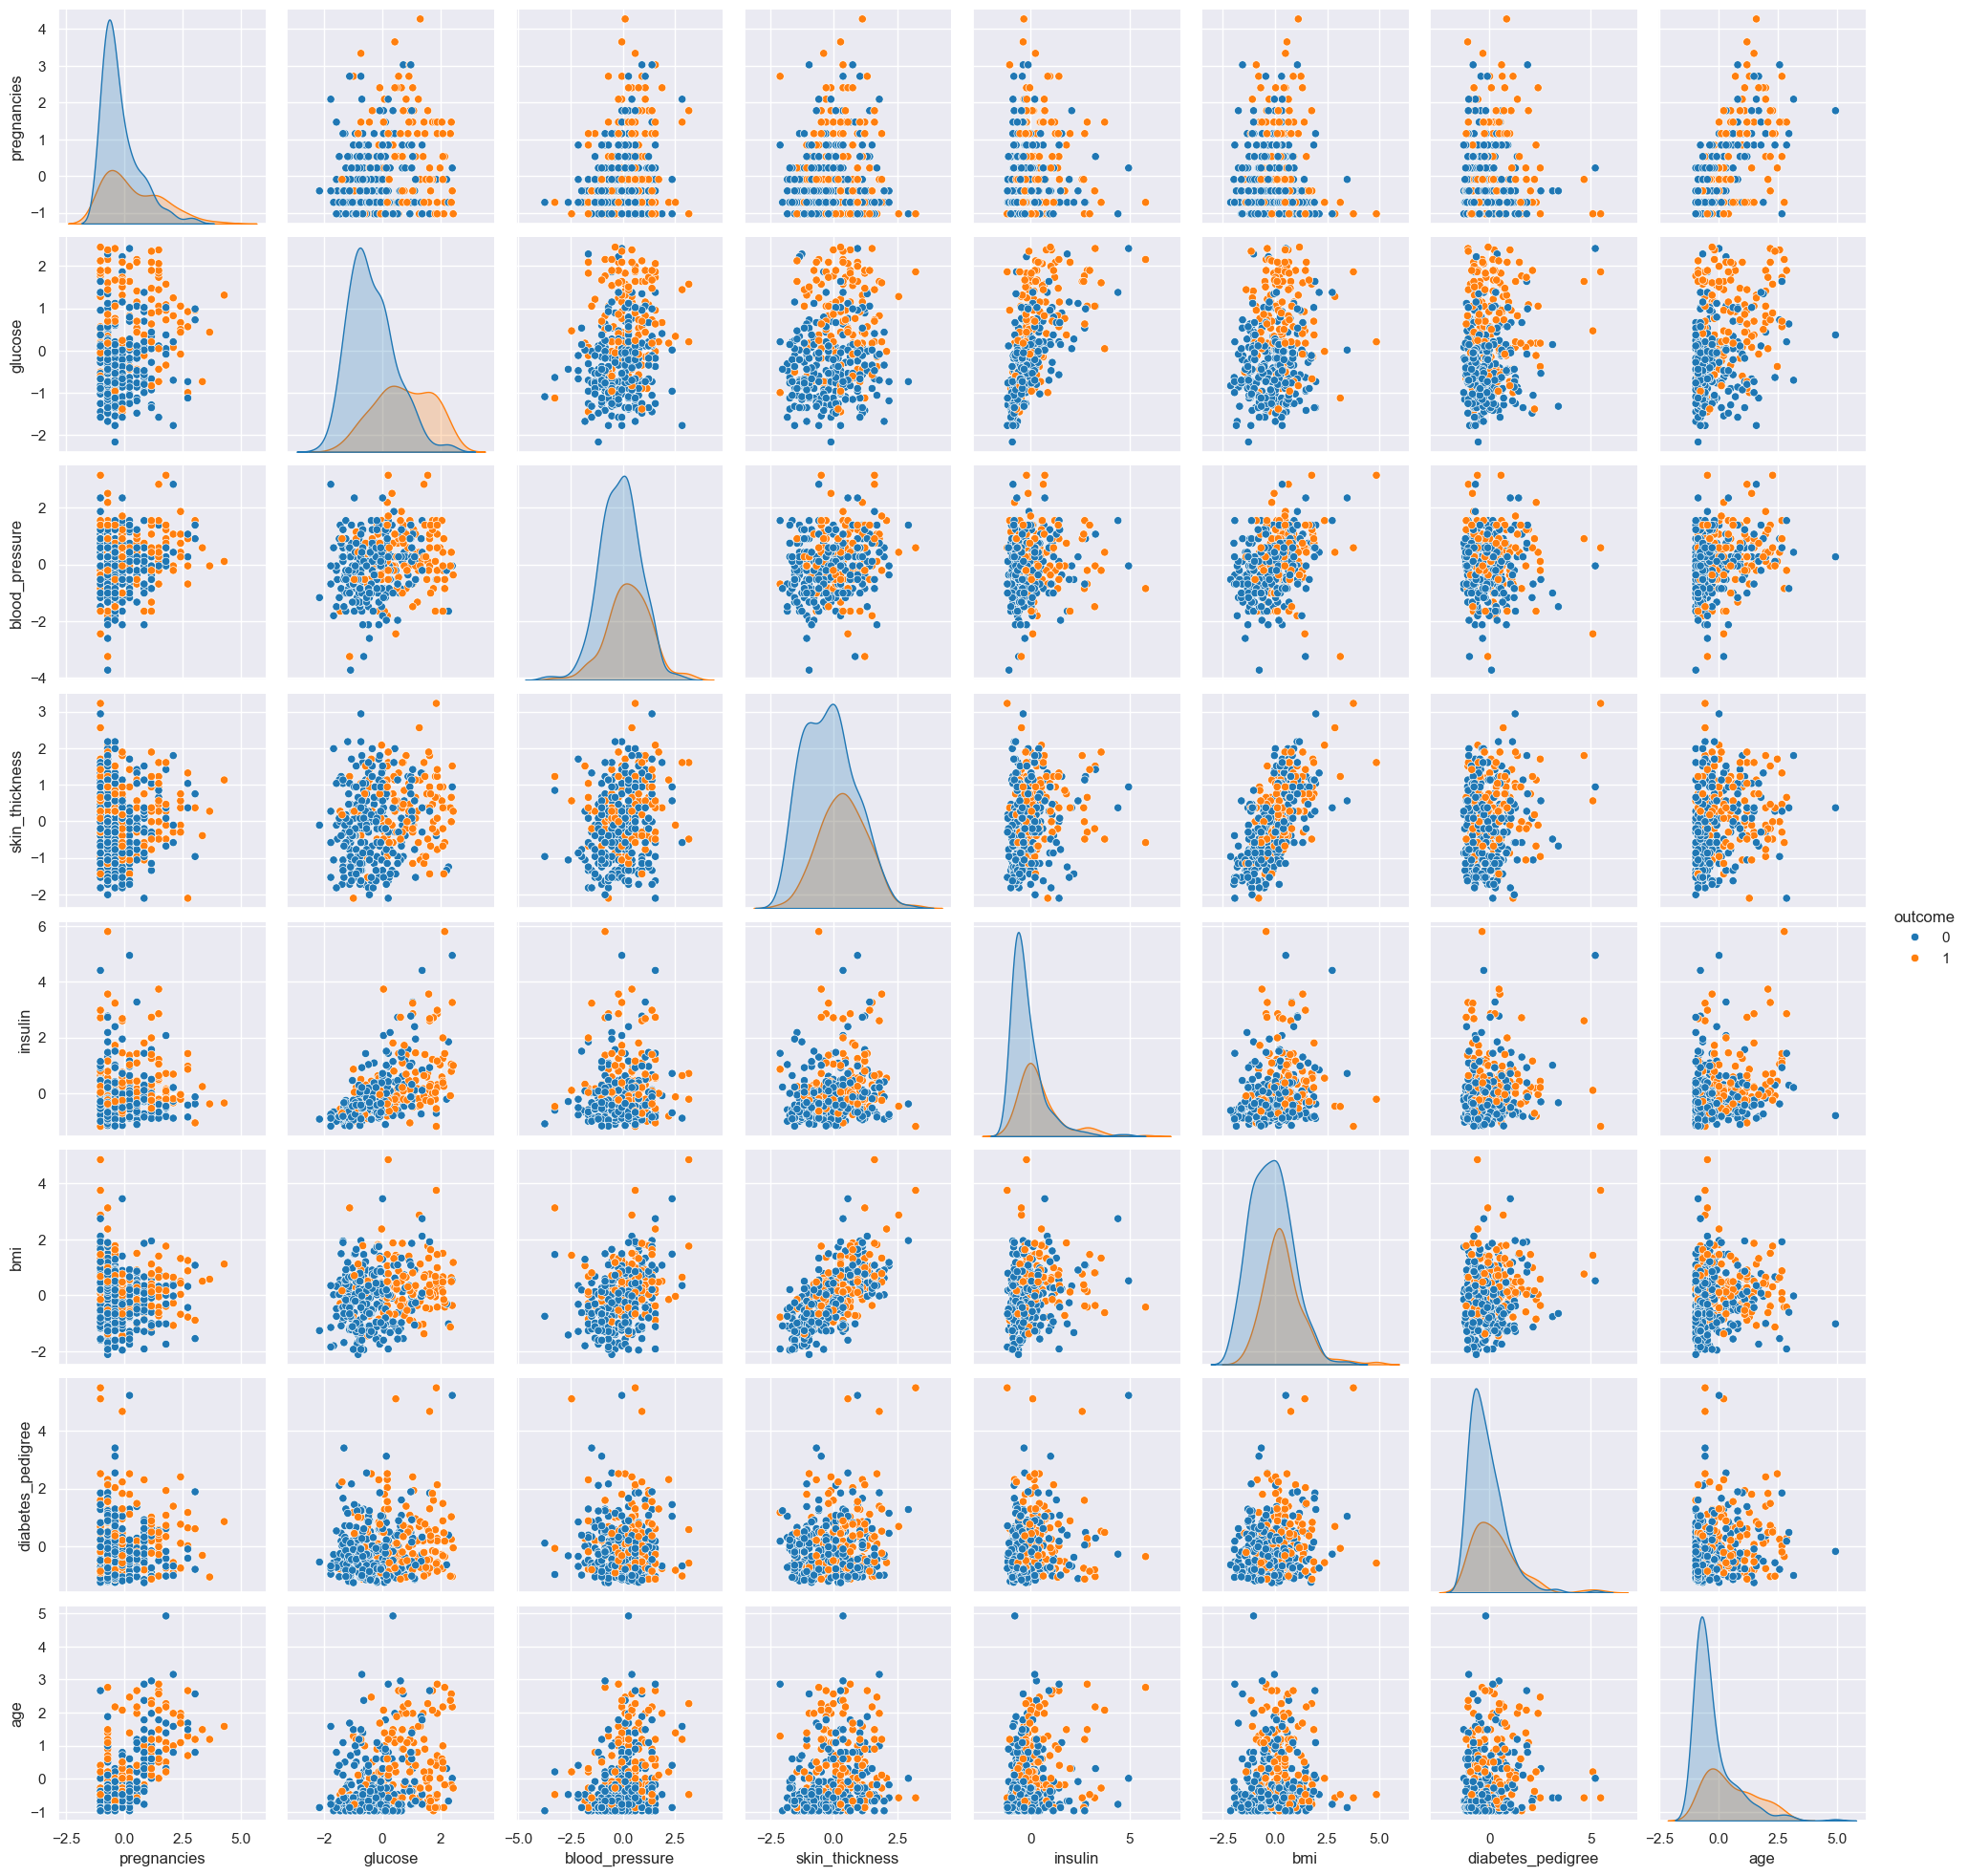

In [235]:
sns.pairplot(data=pd.concat([X_nopca, y_nopca], axis=1), hue='outcome', palette='tab10');

#### Support Vector Classifier </a>

In [236]:
# Employing cross-validation in order to find the best value for C
kfold = skm.KFold(10, random_state=42, shuffle=True)

grid_linear_nopca = skm.GridSearchCV(SVC(kernel='linear'), {'C': [0.01, 0.1, 1, 5, 10, 100]}, refit=True, cv=kfold, scoring='recall') 

# Fitting the cross-validation
grid_linear_nopca.fit(X_nopca_train, y_nopca_train)

grid_linear_nopca.best_params_

{'C': 5}

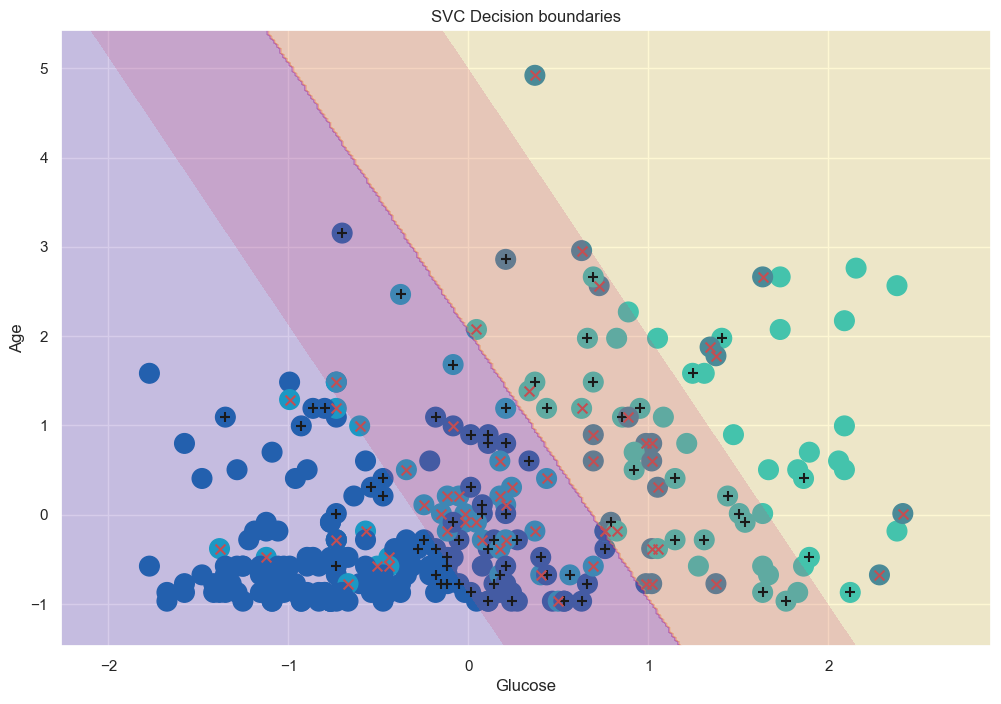

In [237]:
# Fitting the SVC
svm_linear_nopca = SVC(kernel='linear', C=grid_linear_nopca.best_params_['C'])
svm_linear_nopca.fit(X_nopca_train, y_train)

# Plotting
fig_linear_nopca, ax_linear_nopca = plt.subplots(figsize=(12,8))
plot_svm(X_nopca_train, y_train, svm_linear_nopca, ax=ax_linear_nopca, features=(1, 7))
plt.xlabel("Glucose")
plt.ylabel("Age")
plt.title("SVC Decision boundaries");

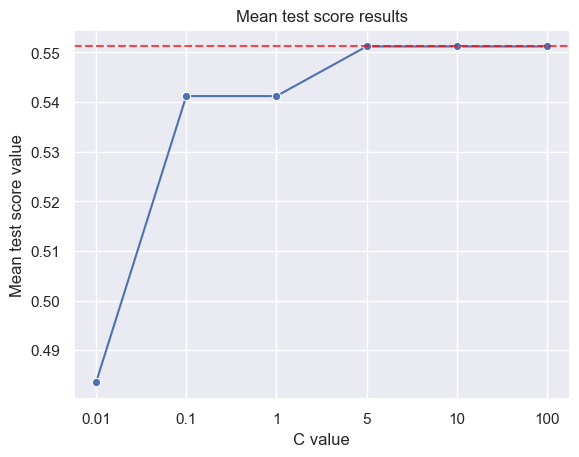

In [238]:
sns.lineplot(x=[1, 2, 3, 4, 5, 6], y=grid_linear_nopca.cv_results_['mean_test_score'], marker='o')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6], labels=[0.01, 0.1, 1, 5, 10, 100])
plt.axhline(max(grid_linear_nopca.cv_results_['mean_test_score']), color='red', alpha=0.7, linestyle="--")
plt.xlabel("C value")
plt.ylabel("Mean test score value")
plt.title("Mean test score results");

##### Training

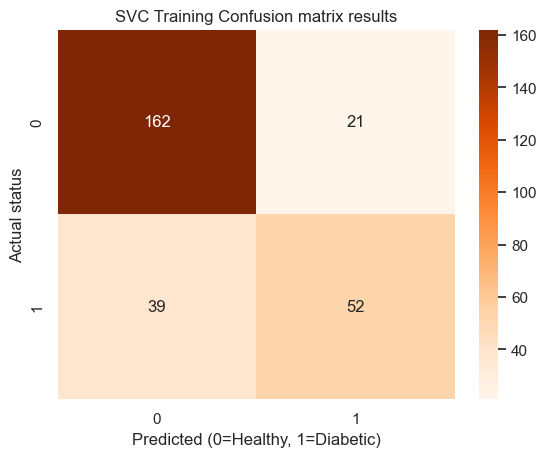

In [239]:
train_pred_svc_nopca = svm_linear_nopca.predict(X_nopca_train)
train_cm_linear_nopca = confusion_matrix(y_nopca_train, train_pred_svc_nopca)
sns.heatmap(train_cm_linear_nopca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("SVC Training Confusion matrix results");

In [240]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_nopca_train, train_pred_svc_nopca)], 
                   'Recall': [recall_score(y_nopca_train, train_pred_svc_nopca)], 
                   'Precision': [precision_score(y_nopca_train, train_pred_svc_nopca)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.781022  0.571429   0.712329

##### Testing

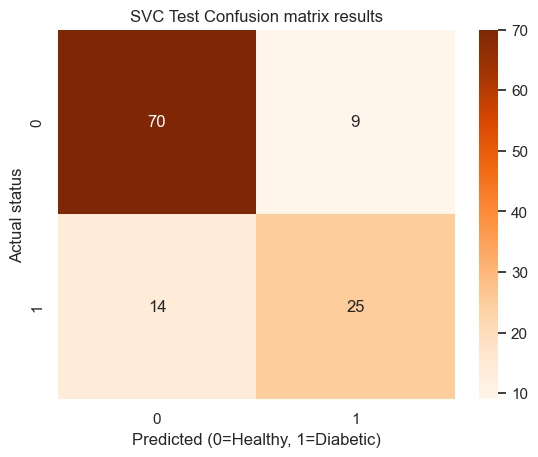

In [241]:
pred_svc_nopca = svm_linear_nopca.predict(X_nopca_test)
cm_linear_nopca = confusion_matrix(y_nopca_test, pred_svc_nopca)
sns.heatmap(cm_linear_nopca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("SVC Test Confusion matrix results");

In [242]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_nopca_test, pred_svc_nopca)], 
                   'Recall': [recall_score(y_nopca_test, pred_svc_nopca)], 
                   'Precision': [precision_score(y_nopca_test, pred_svc_nopca)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.805085  0.641026   0.735294

#### Support Vector Machine, RBF kernel </a>

In [243]:
# Employing cross-validation in order to find the best value for C
kfold = skm.KFold(10, random_state=42, shuffle=True)

grid_rbf_nopca = skm.GridSearchCV(SVC(kernel='rbf'), {'C': [0.01, 0.1, 1, 5, 10, 100], 'gamma': [0.01, 0.1, 0.5, 1, 2, 3, 4, 5]}, refit=True, cv=kfold, scoring='recall') 

# Fitting the cross-validation
grid_rbf_nopca.fit(X_nopca_train, y_nopca_train)

grid_rbf_nopca.best_params_

{'C': 100, 'gamma': 0.1}

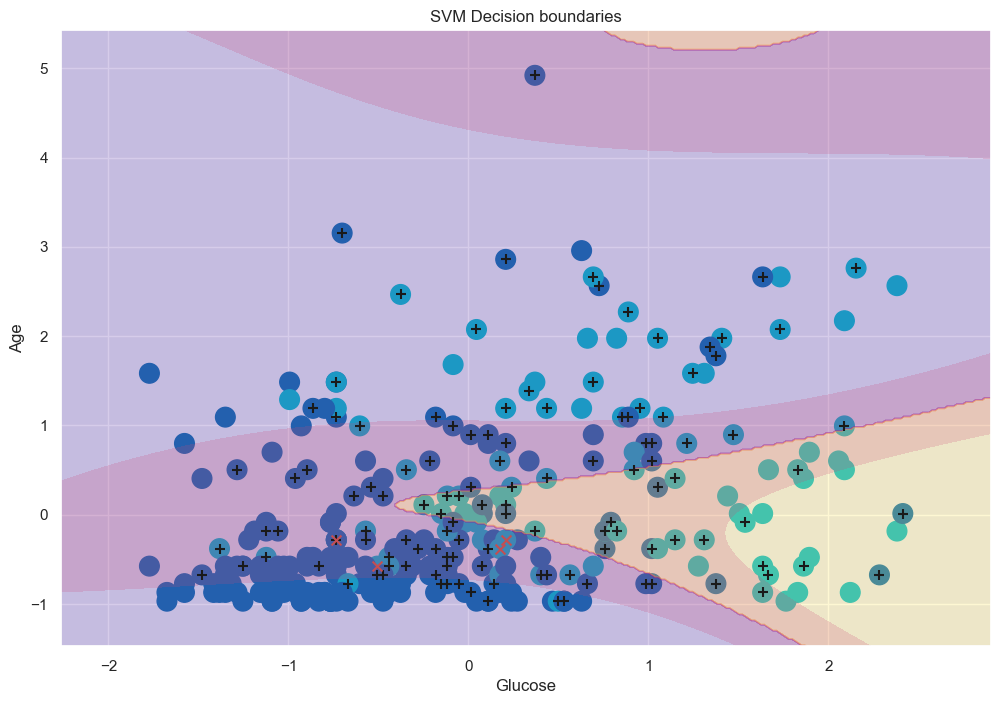

In [244]:
# Fitting the SVM
svm_rbf_nopca = SVC(kernel='rbf', C=grid_rbf_nopca.best_params_['C'], gamma=grid_rbf_nopca.best_params_['gamma'])
svm_rbf_nopca.fit(X_nopca_train, y_train)

# Plotting
fig_rbf_nopca, ax_rbf_nopca = plt.subplots(figsize=(12,8))
plot_svm(X_nopca_train, y_train, svm_rbf_nopca, ax=ax_rbf_nopca, features=(1, 7))
plt.xlabel("Glucose")
plt.ylabel("Age")
plt.title("SVM Decision boundaries");

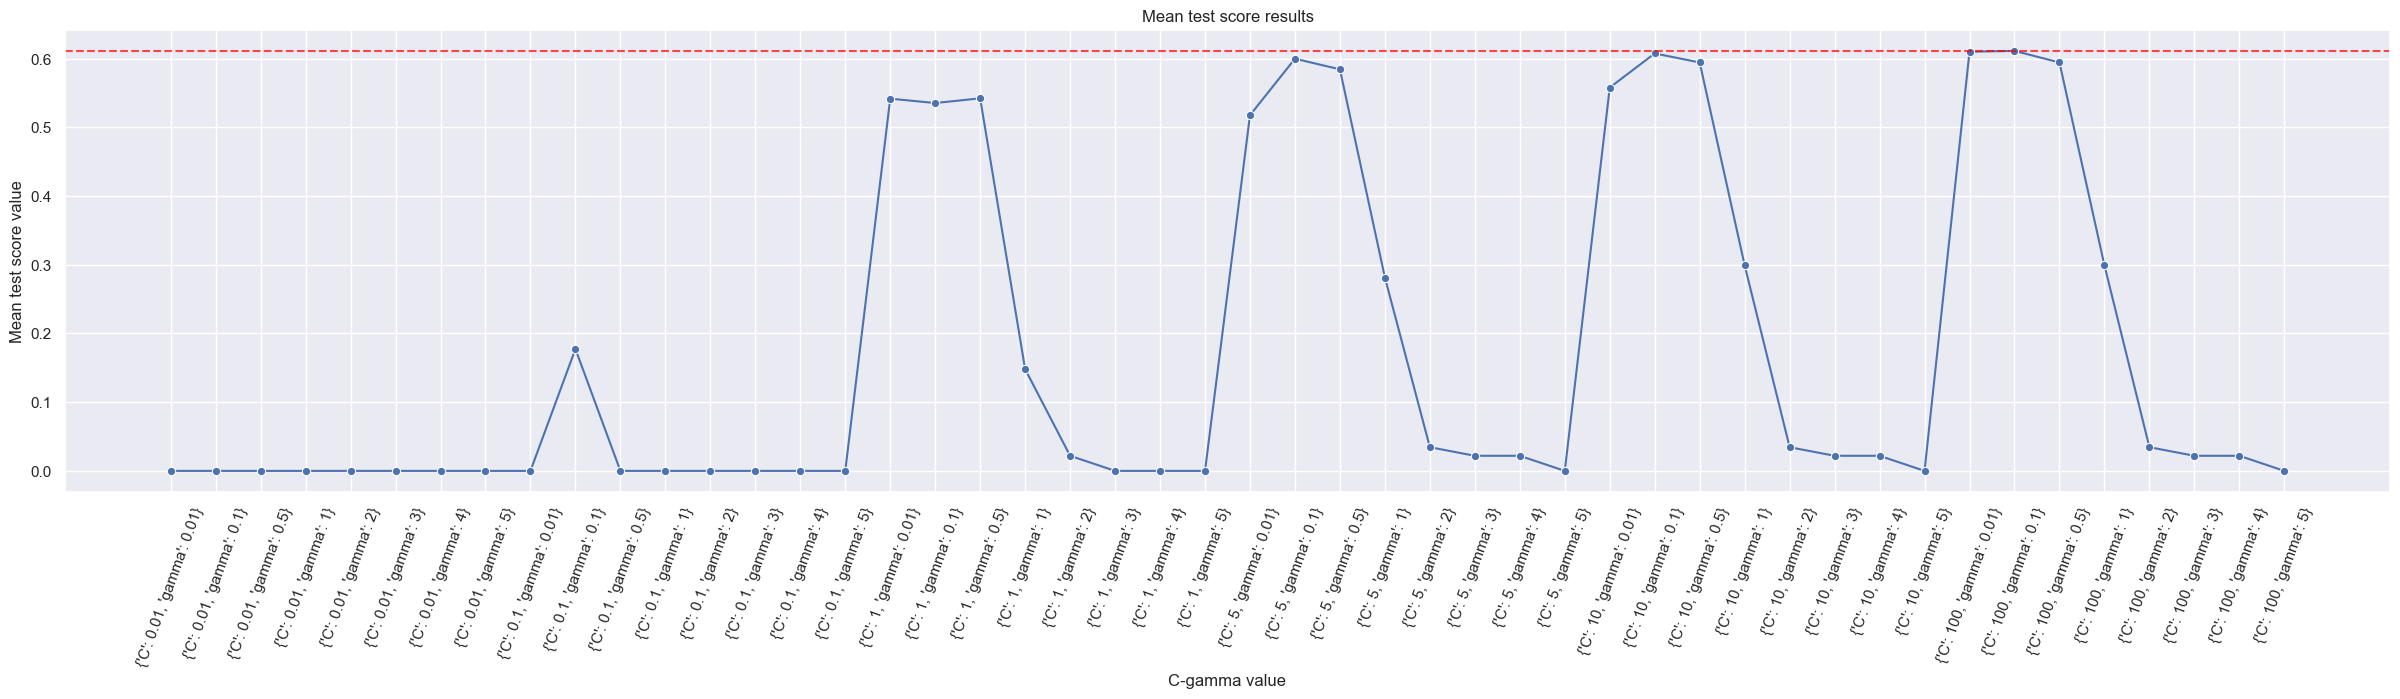

In [245]:
plt.figure(figsize=(30, 6))
sns.lineplot(x=range(0, len(grid_rbf_nopca.cv_results_['mean_test_score'])), y=grid_rbf_nopca.cv_results_['mean_test_score'], marker='o')
plt.axhline(max(grid_rbf_nopca.cv_results_['mean_test_score']), color='red', alpha=0.7, linestyle="--")
plt.xticks(ticks=range(0, len(grid_rbf_nopca.cv_results_['mean_test_score'])), labels=grid_rbf_nopca.cv_results_['params'], rotation=70)
plt.xlabel("C-gamma value")
plt.ylabel("Mean test score value")
plt.title("Mean test score results");

##### Training

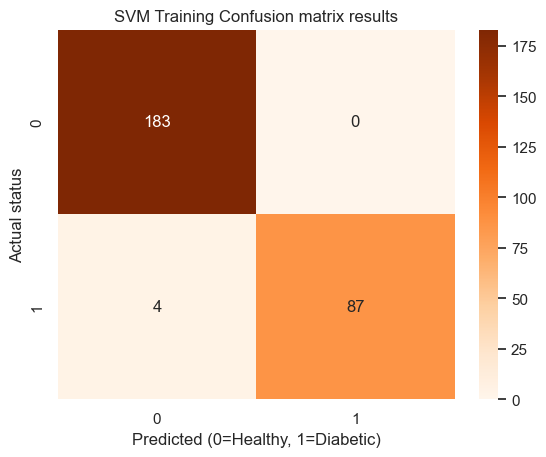

In [246]:
train_pred_svm_nopca = svm_rbf_nopca.predict(X_nopca_train)
train_cm_rbf_nopca = confusion_matrix(y_nopca_train, train_pred_svm_nopca)
sns.heatmap(train_cm_rbf_nopca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("SVM Training Confusion matrix results");

In [247]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_nopca_train, train_pred_svm_nopca)], 
                   'Recall': [recall_score(y_nopca_train, train_pred_svm_nopca)], 
                   'Precision': [precision_score(y_nopca_train, train_pred_svm_nopca)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.985401  0.956044        1.0

##### Testing

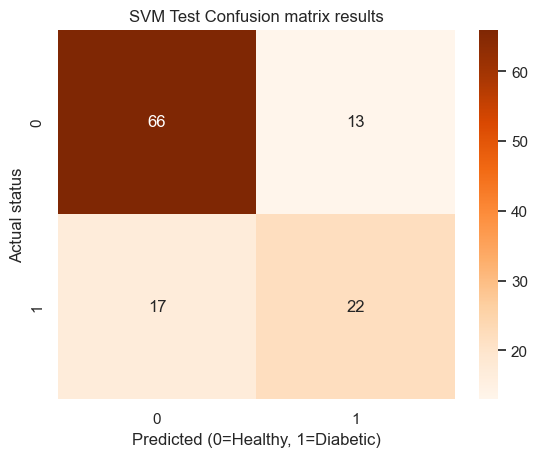

In [248]:
pred_svm_nopca = svm_rbf_nopca.predict(X_nopca_test)
cm_rbf_nopca = confusion_matrix(y_nopca_test, pred_svm_nopca)
sns.heatmap(cm_rbf_nopca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("SVM Test Confusion matrix results");

In [249]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_nopca_test, pred_svm_nopca)], 
                   'Recall': [recall_score(y_nopca_test, pred_svm_nopca)], 
                   'Precision': [precision_score(y_nopca_test, pred_svm_nopca)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.745763  0.564103   0.628571

#### Logistic regression </a>

In [250]:
# Fitting the Logistic regression
lgs_nopca = LogisticRegression()
lgs_nopca.fit(X_nopca_train, y_nopca_train)

LogisticRegression()

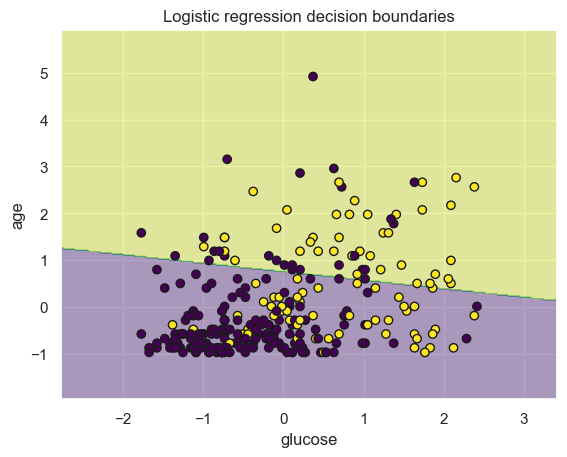

In [251]:
plot_multiclass_decision_boundary_nopca(lgs_nopca, X_nopca_train, y_nopca_train, cols=('glucose', 'age'))
plt.title("Logistic regression decision boundaries");

##### Training

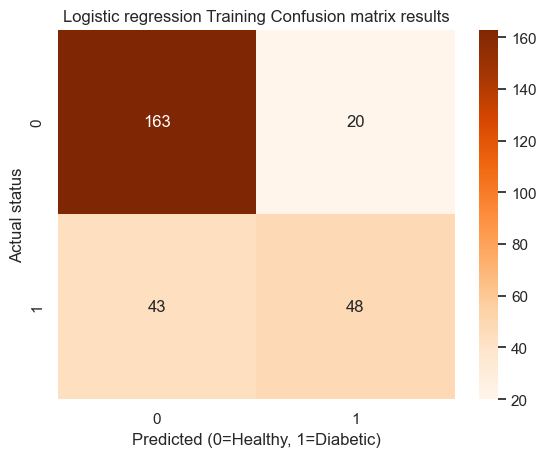

In [252]:
train_pred_lgs_nopca = lgs_nopca.predict(X_nopca_train)
train_cm_lgs_nopca = confusion_matrix(y_nopca_train, train_pred_lgs_nopca)
sns.heatmap(train_cm_lgs_nopca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("Logistic regression Training Confusion matrix results");

In [253]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_nopca_train, train_pred_lgs_nopca)], 
                   'Recall': [recall_score(y_nopca_train, train_pred_lgs_nopca)], 
                   'Precision': [precision_score(y_nopca_train, train_pred_lgs_nopca)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.770073  0.527473   0.705882

##### Testing

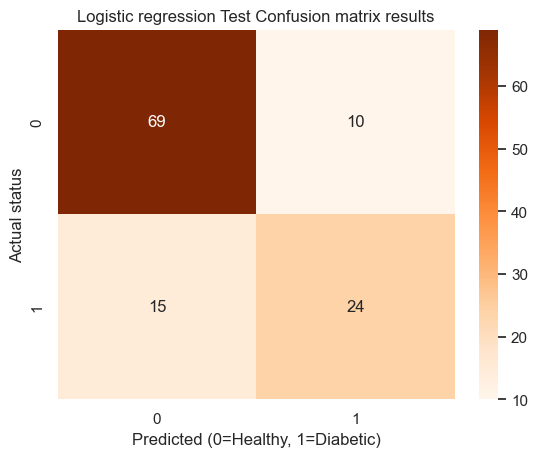

In [254]:
pred_lgs_nopca = lgs_nopca.predict(X_nopca_test)
cm_lgs_nopca = confusion_matrix(y_nopca_test, pred_lgs_nopca)
sns.heatmap(cm_lgs_nopca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("Logistic regression Test Confusion matrix results");

In [255]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_nopca_test, pred_lgs_nopca)], 
                   'Recall': [recall_score(y_nopca_test, pred_lgs_nopca)], 
                   'Precision': [precision_score(y_nopca_test, pred_lgs_nopca)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.788136  0.615385   0.705882

#### K-NN </a>

In [256]:
grid_knn_nopca = skm.GridSearchCV(KNeighborsClassifier(), {'n_neighbors': range(1,20)}, refit=True, cv=kfold, scoring='recall') 

# Fitting the cross-validation
grid_knn_nopca.fit(X_nopca_train, y_nopca_train)

grid_knn_nopca.best_params_

{'n_neighbors': 1}

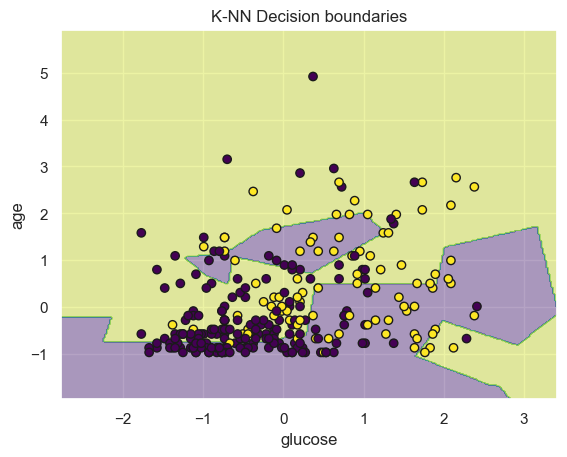

In [257]:
# Fitting the KNN
knn_nopca = KNeighborsClassifier(n_neighbors=grid_knn_nopca.best_params_['n_neighbors'])
knn_nopca.fit(X_nopca_train, y_nopca_train)

plot_multiclass_decision_boundary_nopca(knn_nopca, X_nopca_train, y_nopca_train, cols=('glucose', 'age'))
plt.title("K-NN Decision boundaries");

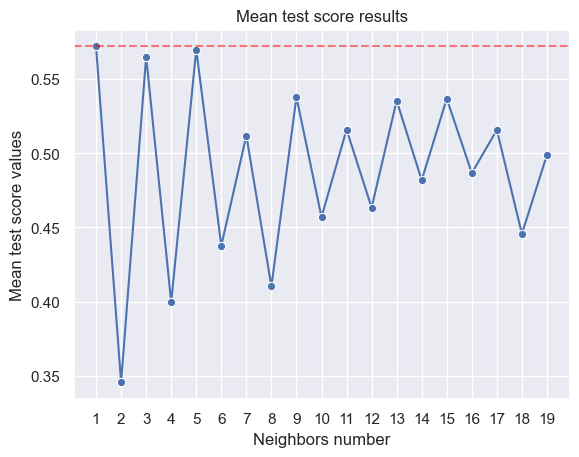

In [258]:
sns.lineplot(x=range(1,20) , y=grid_knn_nopca.cv_results_['mean_test_score'], marker='o')
plt.axhline(y=max(grid_knn_nopca.cv_results_['mean_test_score']), color='red', alpha=0.5, linestyle="--")
plt.xticks(range(1,20))
plt.xlabel("Neighbors number")
plt.ylabel("Mean test score values")
plt.title("Mean test score results");

##### Training

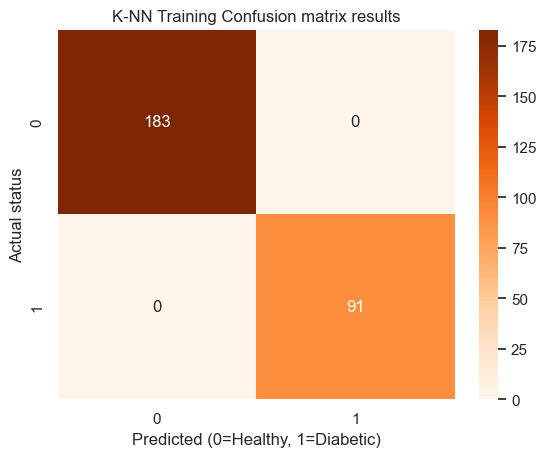

In [259]:
train_pred_knn_nopca = knn_nopca.predict(X_nopca_train)
train_cm_knn_nopca = confusion_matrix(y_nopca_train, train_pred_knn_nopca)
sns.heatmap(train_cm_knn_nopca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("K-NN Training Confusion matrix results");

In [260]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_nopca_train, train_pred_knn_nopca)], 
                   'Recall': [recall_score(y_nopca_train, train_pred_knn_nopca)], 
                   'Precision': [precision_score(y_nopca_train, train_pred_knn_nopca)]},
            index=['Values']
)

Accuracy  Recall  Precision
Values       1.0     1.0        1.0

##### Testing

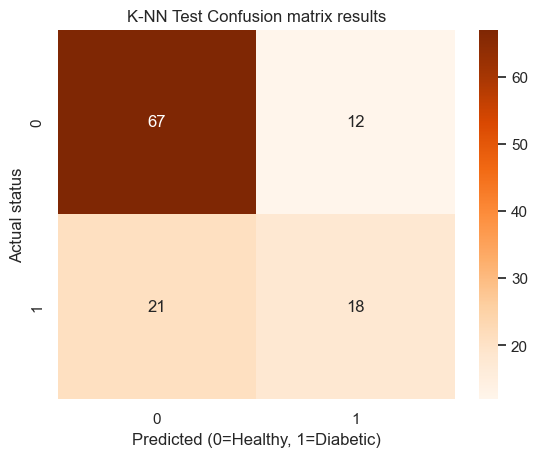

In [261]:
pred_knn_nopca = knn_nopca.predict(X_nopca_test)
cm_knn_nopca = confusion_matrix(y_nopca_test, pred_knn_nopca)
sns.heatmap(cm_knn_nopca, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted (0=Healthy, 1=Diabetic)')
plt.ylabel('Actual status')
plt.title("K-NN Test Confusion matrix results");

In [262]:
pd.DataFrame(data={'Accuracy': [accuracy_score(y_nopca_test, pred_knn_nopca)], 
                   'Recall': [recall_score(y_nopca_test, pred_knn_nopca)], 
                   'Precision': [precision_score(y_nopca_test, pred_knn_nopca)]},
            index=['Values']
)

Accuracy    Recall  Precision
Values  0.720339  0.461538        0.6

### Models performance comparison

In [263]:
pca_scores = []

# PCA SVC
y_score_svc = svm_linear.decision_function(X_test)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_score_svc)
auc_value_svc = roc_auc_score(y_test, y_score_svc)
pca_scores.append((fpr_svc, tpr_svc, auc_value_svc))

# PCA SVM
y_score_svm = svm_rbf.decision_function(X_test)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_score_svm)
auc_value_svm = roc_auc_score(y_test, y_score_svm)
pca_scores.append((fpr_svm, tpr_svm, auc_value_svm))

# Logistic regression SVC
y_score_lgs = lgs.decision_function(X_test)
fpr_lgs, tpr_lgs, thresholds_lgs = roc_curve(y_test, y_score_lgs)
auc_value_lgs = roc_auc_score(y_test, y_score_lgs)
pca_scores.append((fpr_lgs, tpr_lgs, auc_value_lgs))

# PCA K-NN
y_score_knn = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_score_knn)
auc_value_knn = roc_auc_score(y_test, y_score_knn)
pca_scores.append((fpr_knn, tpr_knn, auc_value_knn))

In [264]:
nopca_scores = []

# No-PCA SVC
y_score_svc_nopca = svm_linear_nopca.decision_function(X_nopca_test)
fpr_svc_nopca, tpr_svc_nopca, thresholds_svc_nopca = roc_curve(y_nopca_test, y_score_svc_nopca)
auc_value_svc_nopca = roc_auc_score(y_nopca_test, y_score_svc_nopca)
nopca_scores.append((fpr_svc_nopca, tpr_svc_nopca, auc_value_svc_nopca))

# No-PCA SVM
y_score_svm_nopca = svm_rbf_nopca.decision_function(X_nopca_test)
fpr_svm_nopca, tpr_svm_nopca, thresholds_svm_nopca = roc_curve(y_nopca_test, y_score_svm_nopca)
auc_value_svm_nopca = roc_auc_score(y_nopca_test, y_score_svm_nopca)
nopca_scores.append((fpr_svm_nopca, tpr_svm_nopca, auc_value_svm_nopca))

# No-Logistic regression SVC
y_score_lgs_nopca = lgs_nopca.decision_function(X_nopca_test)
fpr_lgs_nopca, tpr_lgs_nopca, thresholds_lgs_nopca = roc_curve(y_nopca_test, y_score_lgs_nopca)
auc_value_lgs_nopca = roc_auc_score(y_nopca_test, y_score_lgs_nopca)
nopca_scores.append((fpr_lgs_nopca, tpr_lgs_nopca, auc_value_lgs_nopca))

# No-PCA K-NN
y_score_knn_nopca = knn_nopca.predict_proba(X_nopca_test)[:, 1]
fpr_knn_nopca, tpr_knn_nopca, thresholds_knn_nopca = roc_curve(y_nopca_test, y_score_knn_nopca)
auc_value_knn_nopca = roc_auc_score(y_nopca_test, y_score_knn_nopca)
nopca_scores.append((fpr_knn_nopca, tpr_knn_nopca, auc_value_knn_nopca))

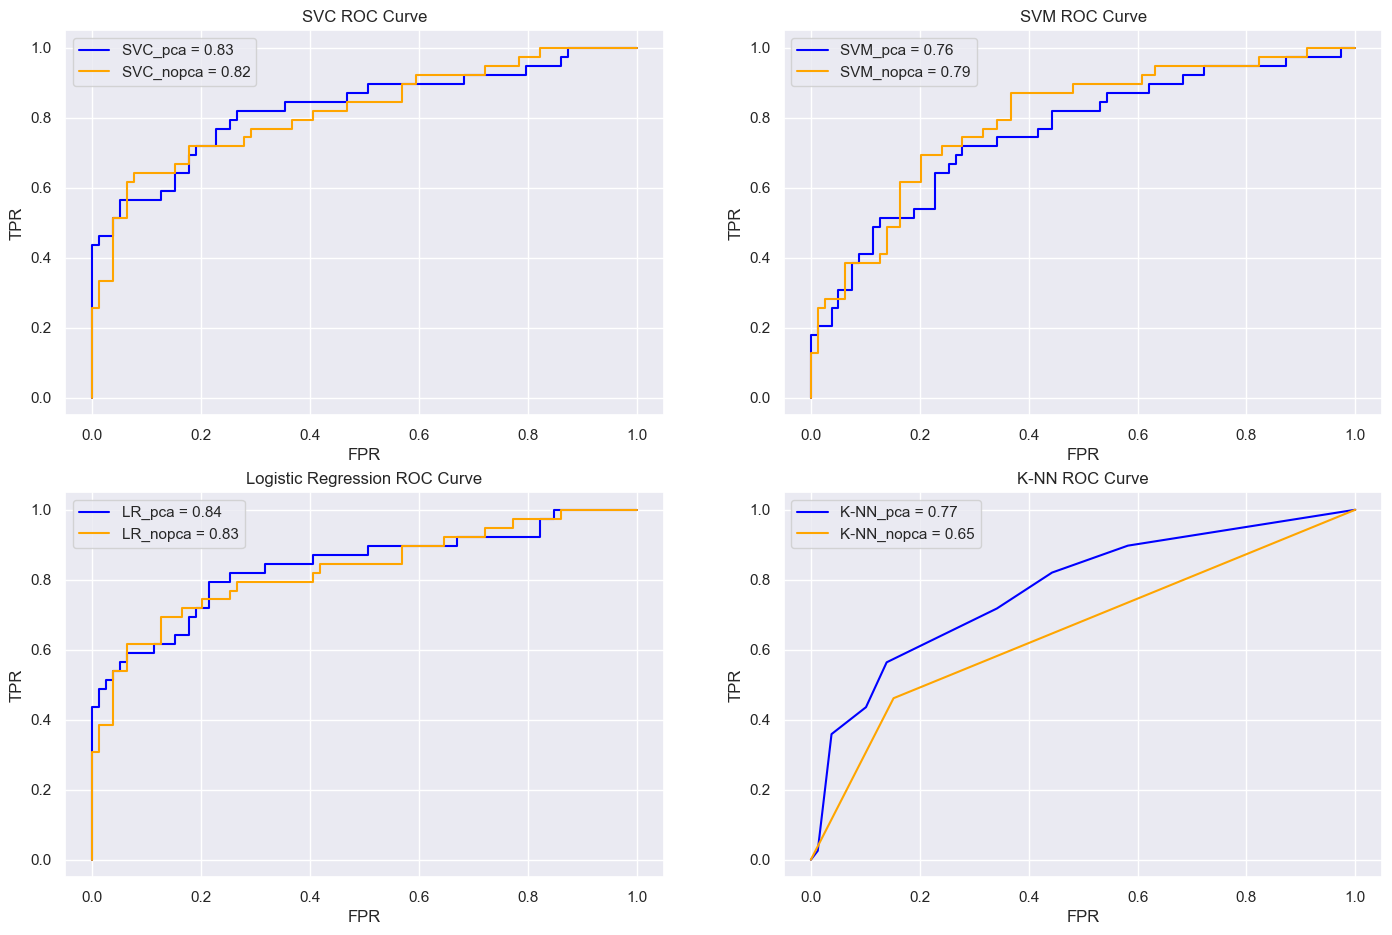

In [265]:
fig_comp, ax_comp = plt.subplots(nrows=2, ncols=2, figsize=(17, 11))

# SVC
sns.lineplot(x=pca_scores[0][0], y=pca_scores[0][1], color='blue', label=f'SVC_pca = {pca_scores[0][2]:.2f}', ax=ax_comp[0][0], estimator=None, sort=False)
sns.lineplot(x=nopca_scores[0][0], y=nopca_scores[0][1], color='orange', label=f'SVC_nopca = {nopca_scores[0][2]:.2f}', ax=ax_comp[0][0], estimator=None, sort=False)
ax_comp[0][0].set_xlabel("FPR")
ax_comp[0][0].set_ylabel("TPR")
ax_comp[0][0].set_title("SVC ROC Curve")

# SVM
sns.lineplot(x=pca_scores[1][0], y=pca_scores[1][1], color='blue', label=f'SVM_pca = {pca_scores[1][2]:.2f}', ax=ax_comp[0][1], estimator=None, sort=False)
sns.lineplot(x=nopca_scores[1][0], y=nopca_scores[1][1], color='orange', label=f'SVM_nopca = {nopca_scores[1][2]:.2f}', ax=ax_comp[0][1], estimator=None, sort=False)
ax_comp[0][1].set_xlabel("FPR")
ax_comp[0][1].set_ylabel("TPR")
ax_comp[0][1].set_title("SVM ROC Curve")

# Logistic regression
sns.lineplot(x=pca_scores[2][0], y=pca_scores[2][1], color='blue', label=f'LR_pca = {pca_scores[2][2]:.2f}', ax=ax_comp[1][0], estimator=None, sort=False)
sns.lineplot(x=nopca_scores[2][0], y=nopca_scores[2][1], color='orange', label=f'LR_nopca = {nopca_scores[2][2]:.2f}', ax=ax_comp[1][0], estimator=None, sort=False)
ax_comp[1][0].set_xlabel("FPR")
ax_comp[1][0].set_ylabel("TPR")
ax_comp[1][0].set_title("Logistic Regression ROC Curve")

# K-NN
sns.lineplot(x=pca_scores[3][0], y=pca_scores[3][1], color='blue', label=f'K-NN_pca = {pca_scores[3][2]:.2f}', ax=ax_comp[1][1], estimator=None, sort=False)
sns.lineplot(x=nopca_scores[3][0], y=nopca_scores[3][1], color='orange', label=f'K-NN_nopca = {nopca_scores[3][2]:.2f}', ax=ax_comp[1][1], estimator=None, sort=False)
ax_comp[1][1].set_xlabel("FPR")
ax_comp[1][1].set_ylabel("TPR")
ax_comp[1][1].set_title("K-NN ROC Curve");

Although the AUC of the pairs are comparable, it only represents the chances of the model will rank a randomly chosen diabetic patient higher than a non-diabetic one. AUC helps understanding how good overall the model behave.

In [266]:
# PCA
pd.DataFrame(data={'Training': [round(recall_score(y_train, train_pred_svc), 2),
                                round(recall_score(y_nopca_train, train_pred_svc_nopca), 2),
                                round(recall_score(y_train, train_pred_svm), 2),
                                round(recall_score(y_nopca_train, train_pred_svm_nopca), 2),
                                round(recall_score(y_train, train_pred_lgs), 2),
                                round(recall_score(y_nopca_train, train_pred_lgs_nopca), 2),
                                round(recall_score(y_train, train_pred_knn), 2),
                                round(recall_score(y_nopca_train, train_pred_knn_nopca), 2)],
                    'Testing': [round(recall_score(y_test, pred_svc), 2),
                                round(recall_score(y_nopca_test, pred_svc_nopca), 2),
                                round(recall_score(y_test, pred_svm), 2),
                                round(recall_score(y_nopca_test, pred_svm_nopca), 2),
                                round(recall_score(y_test, pred_lgs), 2),
                                round(recall_score(y_nopca_test, pred_lgs_nopca), 2),
                                round(recall_score(y_test, pred_knn), 2),
                                round(recall_score(y_nopca_test, pred_knn_nopca), 2)]},
                    index=['SVC_PCA', 'SVC_noPCA', 'SVM_PCA', 'SVM_noPCA', 'LGS_PCA', 'LGS_noPCA', 'KNN_PCA', 'KNN_noPCA'])

Training  Testing
SVC_PCA        0.56     0.56
SVC_noPCA      0.57     0.64
SVM_PCA        0.76     0.54
SVM_noPCA      0.96     0.56
LGS_PCA        0.56     0.59
LGS_noPCA      0.53     0.62
KNN_PCA        0.73     0.56
KNN_noPCA      1.00     0.46

The showed dataframe consists of all the results of the employed models on Recall metric.  

**SVC and SVM**  
Support Vector Classifier testing performances were better and more consistent with training performances compared to the Support Vector Machine whose training performances were way higher compared to testing. This could be due Support Vector Machine overfitting because of an overly complex decision boundaries that ended up being too performing on training data and not as performing on unseen data.  

**Logistic regression**  
Logistic regression appeared to be, together with Support Vector Classifier, the most consistent in performances between training and testing, both in the PCA and noPCA results.

**K-NN**  
K-nearest neighbors ended up overfitting way too much, both in the PCA and especially in the noPCA results. In particular, the extreme overfitting showed in the noPCA example proved to be extremely impactful on testing where the Recall was even lower than 0.5

### Models interpretation

<center><img src='images/complexity-interpretability.png'></center>

#### Logistic regression

Logistic regression provides the highest interpretability in the set of chosen models. It is possible to understand the weight of each predictors through their coefficient thanks to log odds. 

The log odds, or logit, is expressed as $$logit(p(X)) = log\left(\frac{p(X)}{1-p(X)}\right) = \beta_0 + \beta_1X + ... + \beta_pX_p$$ and helps understanding the weight of a particular predictor compared to another predictor. 

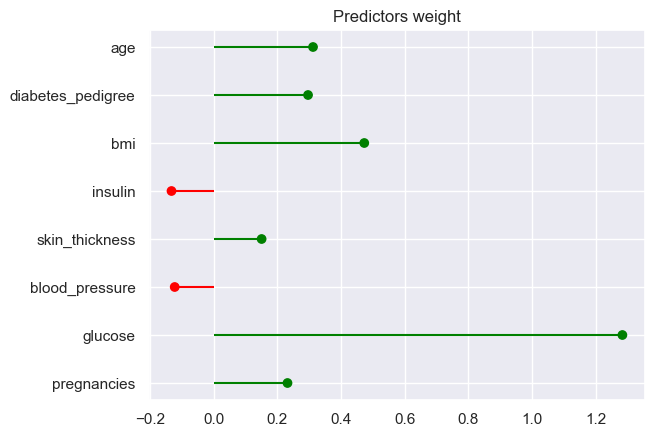

In [267]:
plt.hlines(y=df.columns[:-1], xmin=0, xmax=lgs_nopca.coef_, color=['green' if coef > 0 else 'red' for coef in lgs_nopca.coef_[0]])
plt.scatter(lgs_nopca.coef_, df.columns[:-1], color=['green' if coef > 0 else 'red' for coef in lgs_nopca.coef_[0]])
plt.title("Predictors weight");

It is possible to notice how, for example, `Glucose` weights roughly ~3 times `BMI` in terms of log odds. As for the actual predicted value through the logistic function, $ p(X) = \frac{e^{\beta_0 + \beta_1X_1 + \cdots + \beta_pX_p}}{1+e^{\beta_0 + \beta_1X_1 + \cdots + \beta_pX_p}} $, the calculations are different since an exponential is involved.

Through Logistic regression is also possible to generate decision boundaries.

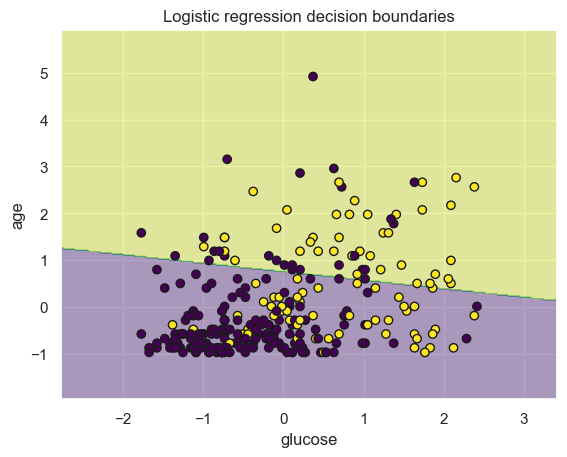

In [268]:
plot_multiclass_decision_boundary_nopca(lgs_nopca, X_nopca_train, y_nopca_train, cols=('glucose', 'age'))
plt.title("Logistic regression decision boundaries");

#### K-NN

K-nearest neighbors doesn't provide a direct relationship between the predictors and their weight like in Logistic regression but instead the only thing that matters is the distance between the new observation that requires to be classified and its K closest neighbors. This provides **decision boundaries** such that the whole space described by the predictors can be assigned to a class or the other. <center><img src ='images/k-nn_decision-boundaries.png'></center>  
In a two predictors scenario, it is possible to split the plane in sub-areas that belong to a class or the other based on majority vote based on the K neighbors.  

The interpretability of the decision boundaries may start to decrease when the number of predictors increases. This happens since the predictors space will become higher than just two dimensions and looking at the 2-dimensional projection of a higher-dimensional space will make it less intuitive about which sub-space belongs to which class.

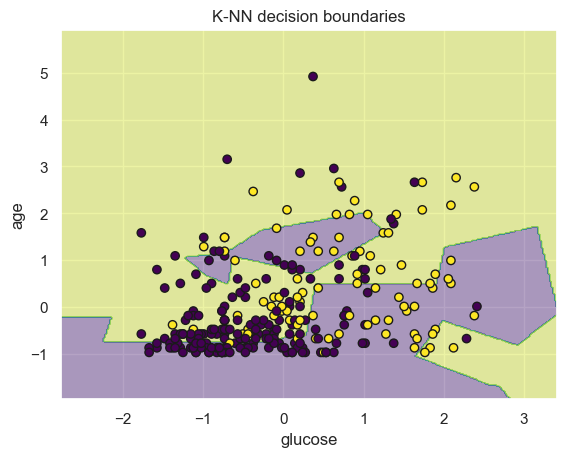

In [269]:
plot_multiclass_decision_boundary_nopca(knn_nopca, X_nopca_train, y_nopca_train, cols=('glucose', 'age'))
plt.title("K-NN decision boundaries");

It is possible to notice that are areas that don't make much sense in the 2-dimensional projection since there appears to be a majority of yellow observations but the underlying area is still assigned to the purple class <center><img src='images/k-nn_decision-boundaries2.png'></center>  This might have been explained if we had the chance to look at the data with its full dimensionality instead of just two dimensions at once.

#### Support Vector Classifier and Support Vector Machine

Similarly to K-nn, also SVC and SVM don't provide a weight of the predictors with respect to the assigned class but instead provide decision boundaries.  

**SVC**  
Support Vector Classifier provides a solution similar to Logistic regression, where the space generated by the predictors is split by a hyperplane. In particular, scikit-learn provides a `model.coef_` array that highlights the importance of the predictors in defining the hyperplane.

In [270]:
plt.hlines(y=df.columns[:-1], xmin=0, xmax=svm_linear_nopca.coef_, color=['green' if coef > 0 else 'red' for coef in svm_linear_nopca.coef_[0]])
plt.scatter(svm_linear_nopca.coef_, df.columns[:-1], color=['green' if coef > 0 else 'red' for coef in svm_linear_nopca.coef_[0]])
plt.title("Predictors impact in generating the margin");

A positive value means that a predictor contributes to the classification of one class while a negative value means that the predictor contributes in the classification of the other class.  

**SVM**  
The interpretability still provided by the SVC becomes even less with SVM since data is projected into a higher-dimensional space through different kernels (like polynomial or RBF) and decision boundaries aren't a "straight" hyperplane anymore.

## Conclusions

The analyzed dataset proved to be an interesting challange since the beginning.  

In the data cleaning part, the dataset showed several unexpected values, the `0`, that needed to be addressed. By checking every predictor it became clear that it wasn't an isolated case but instead a problem affecting most of the predictors. It was assumed that `0` was just a replacement for a missing value since such value was not feasible at all as a body parameter.  

In the data exploration part, especially in the bivariate, in the Heatmap relationship between predictors showed due to the nature of body parameters being closely interconnected and in the Pairplot some variables, like `Glucose`, started to highlighted as possible indicator of patients affected by diabetes. Going further with analyzing directly the association between the explanatory variables and the response variable, `Glucose` again came out to be the predictor with the higher association with `Outcome`, alongside with `Age`.  

In the unsupervised analysis part, it was possible to get a starting grasp on the most meaningful variables (`Glucose`, `BMI`, `Age`) towards the response variable.

In the supervised analysis part, due to lack of interpretability of PCA because of the hardly distinguishible meaning of the Principal Component obtained, the chosen set of models have been employed on both the first 4 Principal Component covering ~80% of the variance and on the standardized dataset. Comparing results of the four models and their performance in both training and test set, on PCA and non-PCA data, it is possible to claim that Logistic regression and SVC came on top both in terms of generalization and Recall performance.  

In conclusions, combining the informations obtained by data exploration, unsupervised and supervised analysis it is possible to highlights how `Glucose`, `BMI` and `Age` appear to be the most impactful predictors in detecting whether or not a patient is affected by diabetes. The knowledge obtained could be employed and monitor these factors in the population relative to the sample analyzed in order to mitigate complications.

**Possible improvements**
- Data size and imbalance: the dataset initial observations, 767, were later decreased to 391 due to the data cleaning and a mild imbalance (~36-64) being present might've been a factor in the performance obtained. A possible improvement could be to implement algorithms like SMOTE and verify how models perform.